In [10]:
# transformer_testing.py
import os, sys, json
import joblib
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score
from matplotlib.ticker import FuncFormatter, MultipleLocator
import logging
import matplotlib.pyplot as plt

import sys
PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
SRC_DIR = str(Path(PROJECT_DIR) / "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from datetime import datetime
from config.settings_hpc import *

logging.basicConfig(level=logging.INFO, format='%(message)s')

# ---------------------------------------------------------------------
# Paths / config
# ---------------------------------------------------------------------


from multiomic_transformer.models.model import MultiomicTransformer
from multiomic_transformer.datasets.dataset import MultiChromosomeDataset, SimpleScaler, fit_simple_scalers

experiment = "model_training_049"
output_dir = Path(PROJECT_DIR) / "experiments" / "mESC_no_scale_linear"
SELECTED_EXPERIMENT_DIR = output_dir / "chr19" / experiment
gpu_log_file = Path(PROJECT_DIR) / "LOGS" / "transformer_logs" / "03_training" / "gpu_usage_transformer_training_3409891.20251107_155906.csv"

GROUND_TRUTH_DIR = os.path.join(PROJECT_DIR, "data/ground_truth_files")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH  = 32
TG_CHUNK = 64

## Investigating single-chromosome training accuracy scaling by cell count

In [2]:
def plot_scaled_R2_across_epochs_multi_dfs(df_dict, dataset_name, chrom_id):
    fig = plt.figure(figsize=(6, 5))
    
    num_train_epochs = []
    for key, df in df_dict.items():
        plt.plot(df.index, df["R2_s"], linewidth=2, label=f"{key} | Best R2 = {df['R2_s'].max():.2f}")
        num_train_epochs.append(df["Epoch"].max())

    plt.title(f"Training {dataset_name} {chrom_id} R2 (scaled)", fontsize=17)
    plt.ylim((0,1))
    plt.xlim((0, min(num_train_epochs)))
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel("Epoch", fontsize=17)
    plt.ylabel("R2", fontsize=17)
    plt.legend(fontsize=10)
    plt.tight_layout()
    
    return fig

def plot_unscaled_R2_across_epochs_multi_dfs(df_dict, dataset_name, chrom_id):
    fig = plt.figure(figsize=(6, 5))
    
    num_train_epochs = []
    for key, df in df_dict.items():
        plt.plot(df.index, df["R2_u"], linewidth=2, label=f"{key} | Best R2 = {df['R2_u'].max():.2f}")
        num_train_epochs.append(df["Epoch"].max())

    plt.title(f"Training {dataset_name} {chrom_id} R2 (unscaled)", fontsize=17)
    plt.ylim((0,1))
    plt.xlim((0, min(num_train_epochs)))
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel("Epoch", fontsize=17)
    plt.ylabel("R2", fontsize=17)
    plt.legend(fontsize=10)
    plt.tight_layout()
    
    return fig

In [ ]:
gpu_cell_num_scaling_dict = {
    "15k metacells": pd.read_csv(OUTPUT_DIR / "testing_chr19_cell_scaling" / "model_training_chr19_2.5k" / "training_log.csv"),
    "10k metacells": pd.read_csv(OUTPUT_DIR / "testing_chr19_cell_scaling" / "model_training_chr19_5k" / "training_log.csv"),
    "5k metacells": pd.read_csv(OUTPUT_DIR / "testing_chr19_cell_scaling" / "model_training_chr19_10k" / "training_log.csv"),
    "2.5k metacells": pd.read_csv(OUTPUT_DIR / "testing_chr19_cell_scaling" / "model_training_chr19_15k" / "training_log.csv"),
}

In [10]:
gpu_model_size_scaling_logs = {
    "d_model: 320": pd.read_csv(OUTPUT_DIR / "testing_chr19_model_size" / "model_training_chr19_320" / "training_log.csv"),
    "d_model: 256": pd.read_csv(OUTPUT_DIR / "testing_chr19_model_size" / "model_training_chr19_256" / "training_log.csv"),
    "d_model: 192": pd.read_csv(OUTPUT_DIR / "testing_chr19_model_size" / "model_training_chr19_192" / "training_log.csv"),
    "d_model: 128": pd.read_csv(OUTPUT_DIR / "testing_chr19_model_size" / "model_training_chr19_128" / "training_log.csv"),
    "d_model: 64": pd.read_csv(OUTPUT_DIR / "testing_chr19_model_size" / "model_training_chr19_64" / "training_log.csv"),
}

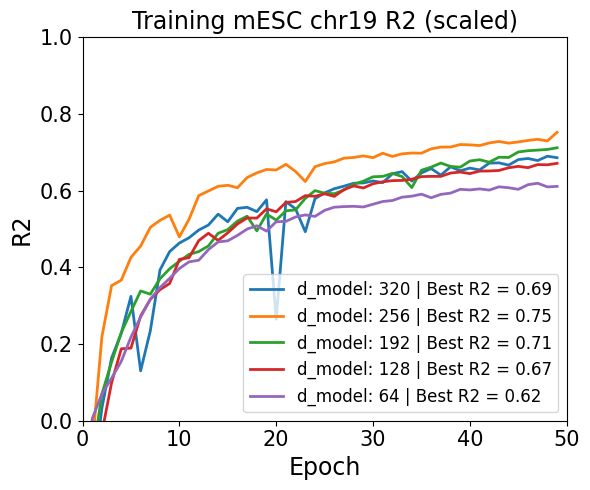

In [11]:
fig = plot_scaled_R2_across_epochs_multi_dfs(gpu_model_size_scaling_logs, "mESC", "chr19")
fig.savefig(OUTPUT_DIR / "testing_chr19_model_size" / "val_scaled_r2_by_model_size.png", dpi=300)
fig.show()

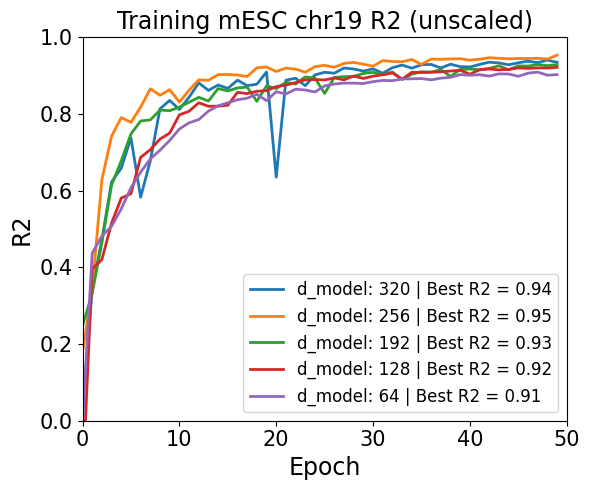

In [12]:
fig = plot_unscaled_R2_across_epochs_multi_dfs(gpu_model_size_scaling_logs, "mESC", "chr19")
fig.savefig(OUTPUT_DIR / "testing_chr19_model_size" / "val_unscaled_r2_by_model_size.png", dpi=300)
fig.show()

## GPU Usage Log

In [57]:
def format_gpu_usage_file(gpu_log_file):
    gpu = pd.read_csv(gpu_log_file)
    gpu.columns = gpu.columns.str.strip()
    gpu["timestamp"] = pd.to_datetime(gpu["timestamp"], errors="coerce")
    gpu["tsec"] = gpu["timestamp"].dt.floor("s")

    gpu["memory_used_gib"]  = gpu["memory.used [MiB]"].astype(str).str.extract(r"(\d+)").astype(float) / 1024
    gpu["memory_total_gib"] = gpu["memory.total [MiB]"].astype(str).str.extract(r"(\d+)").astype(float) / 1024

    t0 = gpu["tsec"].min()
    gpu["elapsed_s"] = (gpu["tsec"] - t0).dt.total_seconds().astype(int)
    gpu["elapsed_min"] = gpu["elapsed_s"] / 60.0             # <— minutes as float

    # mean per second, then carry minutes as a column
    mean_per_sec = (
        gpu.groupby("elapsed_s", as_index=False)["memory_used_gib"]
           .mean()
           .sort_values("elapsed_s")
    )
    mean_per_sec["elapsed_min"] = mean_per_sec["elapsed_s"] / 60.0  # <— add minutes

    total_gib = float(gpu["memory_total_gib"].iloc[0])
    return gpu, mean_per_sec, total_gib

def plot_gpu_usage(gpu_log_dict, align_to_common_duration=False, smooth=None):
    """
    align_to_common_duration: if True, truncate each run to the shortest duration so curves end together.
    smooth: optional int window (in seconds) for a centered rolling mean on memory (e.g., smooth=5).
    """
    fig, ax = plt.subplots(figsize=(7,4))

    totals = []
    max_elapsed_by_run = {}
    for label, (_, mean_per_min, total_gib) in gpu_log_dict.items():
        totals.append(total_gib)
        max_elapsed_by_run[label] = mean_per_min["elapsed_min"].max()

    # shortest duration across runs (so lines end at the same x)
    common_end = min(max_elapsed_by_run.values()) if align_to_common_duration else None

    for label, (_, mean_per_min, total_gib) in gpu_log_dict.items():
        m = mean_per_min.copy()
        if align_to_common_duration and common_end is not None:
            m = m[m["elapsed_min"] <= common_end]

        if smooth and smooth > 1:
            m["memory_used_gib"] = m["memory_used_gib"].rolling(smooth, center=True, min_periods=1).mean()

        ax.plot(m["elapsed_min"], m["memory_used_gib"], label=f"{label}", linewidth=3)

    max_total = max(totals)
    ax.axhline(max_total, linestyle="--", label=f"Max RAM")
    ax.set_ylabel("GiB")
    ax.set_xlabel("Minutes since start")
    ax.set_ylim(0, max_total + 1)
    ax.xaxis.set_major_locator(MultipleLocator(600))  # 600 s = 10 min
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x//60)}"))
    ax.set_xlabel("Minutes since start")
    handles, legend_labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(
            handles,
            legend_labels,
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            borderaxespad=0.0,
        )
    ax.set_title(
        f"Average GPU Memory vs. Elapsed Time\n"
    )
    plt.show()
    return fig

def plot_gpu_usage_boxplots(gpu_log_dict, use_mean_per_sec: bool = True, title_suffix: str = ""):
    """
    gpu_log_dict: {label: (gpu_df, mean_per_sec_df, total_gib)}
        - same structure returned/consumed by format_gpu_usage_file / plot_gpu_usage.
    use_mean_per_sec:
        - True: boxplots over per-second mean memory (smoother).
        - False: boxplots over all raw samples.
    """
    fig, ax = plt.subplots(figsize=(7, 4))

    data = []
    labels = []
    capacities = []

    for label, (gpu_df, mean_per_sec_df, total_gib) in gpu_log_dict.items():
        if use_mean_per_sec:
            series = mean_per_sec_df["memory_used_gib"]
        else:
            series = gpu_df["memory_used_gib"]

        # drop NaNs just in case
        series = series.dropna()
        if series.empty:
            continue

        data.append(series.values)
        labels.append(label)
        capacities.append(total_gib)

    if not data:
        raise ValueError("No GPU usage data available to plot.")

    # Boxplot: one box per run
    bp = ax.boxplot(
        data,
        labels=labels,
        showmeans=True,
        meanline=True,
        patch_artist=True,
    )

    # Optional: horizontal line for (max) GPU capacity across runs
    max_cap = max(capacities)
    ax.axhline(max_cap, linestyle="--", linewidth=1.0,
               label=f"Max capacity")

    ax.set_ylabel("GPU memory used (GiB)")
    base_title = "GPU Memory Usage Distribution per Run"
    if title_suffix:
        base_title += f" ({title_suffix})"
    ax.set_title(base_title)
    handles, legend_labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(
            handles,
            legend_labels,
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            borderaxespad=0.0,
        )

    plt.tight_layout()
    return fig


In [ ]:
gpu_cell_scaling_logs = {
    "15k metacells": format_gpu_usage_file(OUTPUT_DIR / "testing_chr19_cell_scaling" / "model_training_chr19_15k" / "gpu_usage.csv"),
    "10k metacells": format_gpu_usage_file(OUTPUT_DIR / "testing_chr19_cell_scaling" / "model_training_chr19_10k" / "gpu_usage.csv"),
    "5k metacells": format_gpu_usage_file(OUTPUT_DIR / "testing_chr19_cell_scaling" / "model_training_chr19_5k" / "gpu_usage.csv"),
    "2.5K metacells": format_gpu_usage_file(OUTPUT_DIR / "testing_chr19_cell_scaling" / "model_training_chr19_2.5k" / "gpu_usage.csv"),
}

In [18]:
gpu_model_size_scaling_logs = {
    "d_model: 320": format_gpu_usage_file(OUTPUT_DIR / "testing_chr19_model_size" / "model_training_chr19_320" / "gpu_usage.csv"),
    "d_model: 256": format_gpu_usage_file(OUTPUT_DIR / "testing_chr19_model_size" / "model_training_chr19_256" / "gpu_usage.csv"),
    "d_model: 192": format_gpu_usage_file(OUTPUT_DIR / "testing_chr19_model_size" / "model_training_chr19_192" / "gpu_usage.csv"),
    "d_model: 128": format_gpu_usage_file(OUTPUT_DIR / "testing_chr19_model_size" / "model_training_chr19_128" / "gpu_usage.csv"),
    "d_model: 64": format_gpu_usage_file(OUTPUT_DIR / "testing_chr19_model_size" / "model_training_chr19_64" / "gpu_usage.csv"),
}

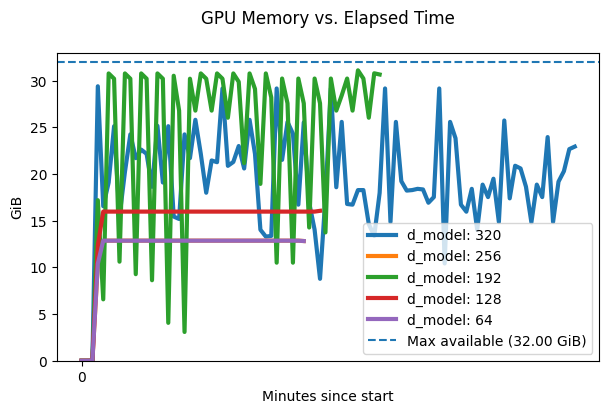

In [ ]:
plot_gpu_usage(gpu_model_size_scaling_logs)
# fig.savefig(SELECTED_EXPERIMENT_DIR / "gpu_memory_requirements.png", dpi=200)

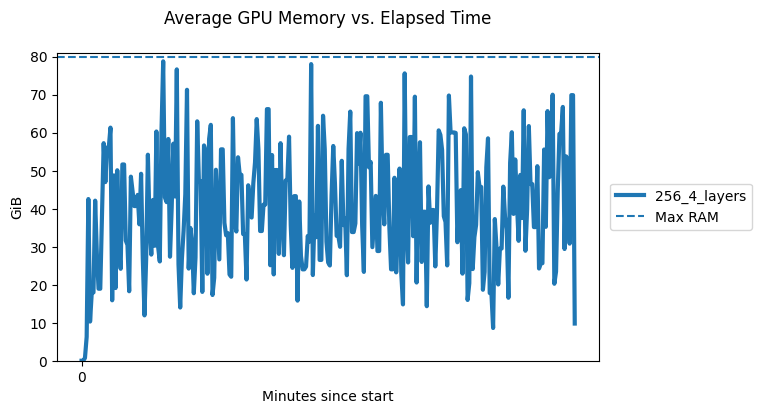

In [58]:
selected_exp_gpu_logs = {
    f"{SELECTED_EXPERIMENT_DIR.name}":format_gpu_usage_file(SELECTED_EXPERIMENT_DIR / "gpu_usage.csv")
}
fig = plot_gpu_usage(selected_exp_gpu_logs)
fig.savefig(SELECTED_EXPERIMENT_DIR / "gpu_memory_requirements.png", dpi=200)

/tmp/ipykernel_1309326/1539291161.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


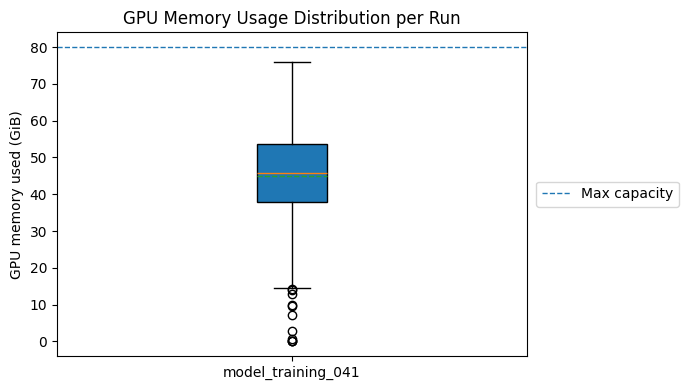

In [10]:
fig = plot_gpu_usage_boxplots(selected_exp_gpu_logs, use_mean_per_sec=True)

In [68]:
grad_accum_gpu = format_gpu_usage_file(OUTPUT_DIR / "all_chroms_grad_accum_chkpt_testing" / "with_grad_accum" / "gpu_usage.csv")
no_grad_accum_gpu = format_gpu_usage_file(OUTPUT_DIR / "all_chroms_grad_accum_chkpt_testing" / "no_grad_accum" / "gpu_usage.csv")

/tmp/ipykernel_1853564/2143512449.py:99: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


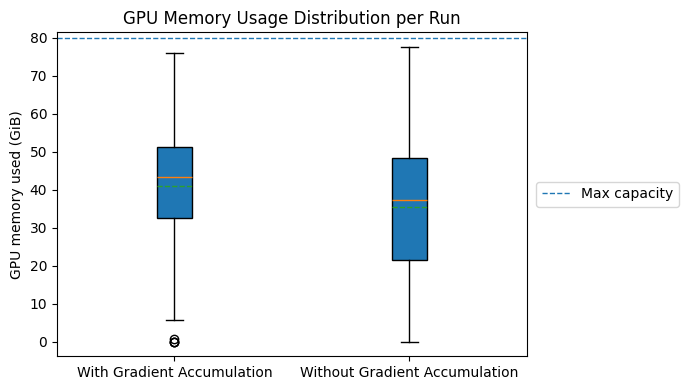

In [69]:
gpu_log_dict = {
    "With Gradient Accumulation": grad_accum_gpu,
    "Without Gradient Accumulation": no_grad_accum_gpu
}
fig = plot_gpu_usage_boxplots(gpu_log_dict, use_mean_per_sec=True)

In [39]:
grad_accum_gpu[0].head()

,timestamp,index,name,utilization.gpu [%],memory.used [MiB],memory.total [MiB],tsec,memory_used_gib,memory_total_gib,elapsed_s,elapsed_min
0,2025-11-07 17:10:22.216,0,NVIDIA A100 80GB PCIe,0 %,0 MiB,81920 MiB,2025-11-07 17:10:22,0.000000,80.0,0,0.0
1,2025-11-07 17:10:22.220,1,NVIDIA A100 80GB PCIe,0 %,0 MiB,81920 MiB,2025-11-07 17:10:22,0.000000,80.0,0,0.0
2,2025-11-07 17:10:22.224,2,NVIDIA A100 80GB PCIe,0 %,0 MiB,81920 MiB,2025-11-07 17:10:22,0.000000,80.0,0,0.0
3,2025-11-07 17:10:22.227,3,NVIDIA A100 80GB PCIe,0 %,0 MiB,81920 MiB,2025-11-07 17:10:22,0.000000,80.0,0,0.0
4,2025-11-07 17:10:52.232,0,NVIDIA A100 80GB PCIe,0 %,4 MiB,81920 MiB,2025-11-07 17:10:52,0.003906,80.0,30,0.5


In [ ]:
grad_accum_df = grad_accum_gpu[0]
no_grad_accum_df = no_grad_accum_gpu[0]
print(f"With Gradient Accumulation:")
print(f"  - Training Time: {grad_accum_df.elapsed_min.max():.0f} min")
print(f"  - Mean GPU Usage: {grad_accum_df.memory_used_gib.mean():.0f} GiB")

print(f"\nWithout Gradient Accumulation:")
print(f"  - Training Time: {no_grad_accum_df.elapsed_min.max():.0f} min")
print(f"  - Mean GPU Usage: {no_grad_accum_df.memory_used_gib.mean():.0f} GiB")


## Training Evaluation

In [4]:
training_log_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "training_log.csv"), header=0)
# model_num = "model_training_017"
# training_log_df = pd.read_csv(f"/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC_no_scale_linear/chr19/{model_num}/training_log.csv", header=0)
# training_log_df = pd.read_csv("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC_no_scale_linear/chr19/model_training_012/training_log.csv", header=0)

# gene_near_peaks_df = pd.read_parquet(os.path.join(SAMPLE_DATA_CACHE_DIR, CHROM_ID, f"genes_near_peaks_{CHROM_ID}.parquet"))
# tf_tg_mean_attention_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "tf_tg_mean_attention.csv"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC_no_scale_linear/chr19/model_training_049/eval_results_pearson_corr.png


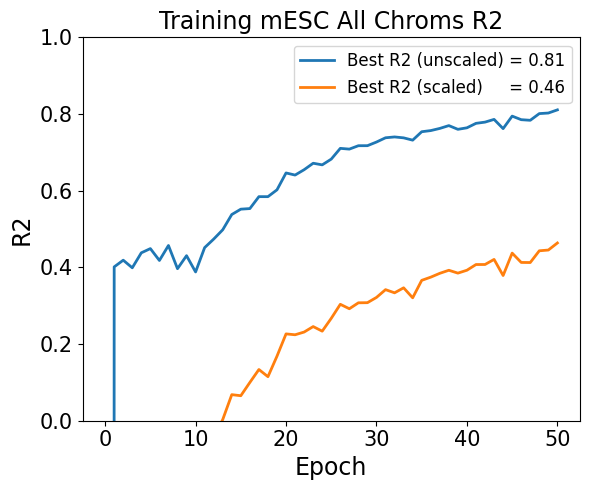

In [11]:
def plot_R2_across_epochs(df, dataset_name, chrom_id):
    fig = plt.figure(figsize=(6, 5))
    plt.plot(df.index, df["R2_u"], linewidth=2, label=f"Best R2 (unscaled) = {df['R2_u'].max():.2f}")
    plt.plot(df.index, df["R2_s"], linewidth=2, label=f"Best R2 (scaled)     = {df['R2_s'].max():.2f}")

    plt.title(f"Training {dataset_name} {chrom_id} R2", fontsize=17)
    plt.ylim((0,1))
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel("Epoch", fontsize=17)
    plt.ylabel("R2", fontsize=17)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    return fig

fig = plot_R2_across_epochs(
    pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "training_log.csv"), header=0), "mESC", "All Chroms")
fig.savefig(os.path.join(SELECTED_EXPERIMENT_DIR, "eval_results_pearson_corr.png"), dpi=300)
print(os.path.join(SELECTED_EXPERIMENT_DIR, "eval_results_pearson_corr.png"))
fig.show()

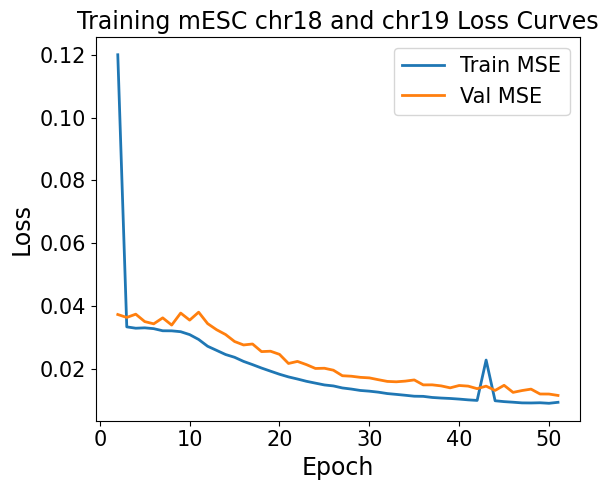

In [12]:
def plot_train_val_loss(df, dataset_name, chrom_id):
    fig = plt.figure(figsize=(6, 5))
    df = df.copy().iloc[1:, :]
    plt.plot(df["Epoch"], df["Train MSE"], label="Train MSE", linewidth=2)
    plt.plot(df["Epoch"], df["Val MSE"], label="Val MSE", linewidth=2)
    # plt.plot(df["Epoch"], df["Train Total Loss"], label="Train Total Loss", linestyle="--", alpha=0.7)

    plt.title(f"Training {dataset_name} {chrom_id} Loss Curves", fontsize=17)
    plt.xlabel("Epoch", fontsize=17)
    plt.ylabel("Loss", fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    # plt.ylim([0, 1])
    # plt.xlim(left=2)
    plt.legend(fontsize=15)
    plt.tight_layout()
    return fig
    
fig = plot_train_val_loss(pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "training_log.csv")), "mESC", "chr18 and chr19")
fig.savefig(os.path.join(SELECTED_EXPERIMENT_DIR, "eval_results_training_loss.png"), dpi=300)
fig.show()

In [7]:
gene_near_peaks_df = pd.read_parquet(os.path.join(SAMPLE_DATA_CACHE_DIR, CHROM_ID, f"genes_near_peaks_{CHROM_ID}.parquet"))
tf_tg_mean_attention_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "tf_tg_mean_attention.csv"))
# gradient_attribution_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "test_results/gradient_attribution.csv"), index_col=0)
# shortcut_matrix_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "test_results/shortcut_matrix.csv"), index_col=0)

In [38]:
import json
with open(os.path.join(COMMON_DATA, "tg_vocab.json")) as f:
    vocab = json.load(f)
print(f"Current vocab size: {len(vocab)}")

Current vocab size: 25090


In [39]:
ckpt_path = os.path.join(SELECTED_EXPERIMENT_DIR, "trained_model.pt")

state = torch.load(ckpt_path, map_location="cuda:0")
print(f"Checkpoint TG scaler size: {state['tg_scaler_mean'].shape[0]}")

Checkpoint TG scaler size: 6852


In [16]:
def nanaware_per_gene_stats(y_true, y_pred, eps=1e-8):
    """Compute per-gene metrics accounting for NaN entries."""
    N, G = y_true.shape
    r2 = np.full(G, np.nan, dtype=np.float64)
    pearson = np.full(G, np.nan, dtype=np.float64)
    mae = np.full(G, np.nan, dtype=np.float64)
    rmse = np.full(G, np.nan, dtype=np.float64)
    n_obs = np.zeros(G, dtype=np.int32)

    for j in range(G):
        mask = np.isfinite(y_true[:, j]) & np.isfinite(y_pred[:, j])
        m = mask.sum()
        n_obs[j] = m
        
        if m < 2:
            continue
            
        yt = y_true[mask, j].astype(np.float64)
        yp = y_pred[mask, j].astype(np.float64)

        diff = yt - yp
        mae[j] = np.mean(np.abs(diff))
        rmse[j] = np.sqrt(np.mean(diff**2))

        yt_c = yt - yt.mean()
        yp_c = yp - yp.mean()
        yt_std = np.sqrt((yt_c**2).sum())
        yp_std = np.sqrt((yp_c**2).sum())
        if yt_std > 0 and yp_std > 0:
            pearson[j] = (yt_c @ yp_c) / (yt_std * yp_std)

        sst = ((yt - yt.mean())**2).sum()
        sse = (diff**2).sum()
        r2[j] = 1.0 - sse / (sst + eps)

    return {"r2": r2, "pearson": pearson, "mae": mae, "rmse": rmse, "n_obs": n_obs}

In [27]:

import os
import torch
from torch.utils.data import DataLoader
from multiomic_transformer.scripts.train import prepare_dataloader

test_loader = torch.load(SELECTED_EXPERIMENT_DIR / "test_loader.pt", weights_only=False)

# 3) Load checkpoint
ckpt_path = os.path.join(SELECTED_EXPERIMENT_DIR, "checkpoint_70.pt")
state = torch.load(ckpt_path, map_location="cpu")  # or map_location=device

# 2) Recreate the same model architecture
model = MultiomicTransformer(
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    d_ff=D_FF,
    dropout=DROPOUT,
    tf_vocab_size=len(state["tf_scaler_mean"]),  # 6852 TF
    tg_vocab_size=len(state["tg_scaler_mean"]),  # 6852 TG
    use_bias=USE_DISTANCE_BIAS,
    use_shortcut=USE_SHORTCUT,
    use_motif_mask=USE_MOTIF_MASK,
)

model.load_state_dict(state["model_state_dict"])
model.eval()


if isinstance(state, dict) and "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)

model.eval()

tf_scaler = SimpleScaler(
    mean=state["tf_scaler_mean"],
    std=state["tf_scaler_std"],
)
tg_scaler = SimpleScaler(
    mean=state["tg_scaler_mean"],
    std=state["tg_scaler_std"],
)

from torch.amp import autocast

test_preds = []
test_tgts = []

NUM_TGS_SUBSET = 500  # Subset of TGs to evaluate
TG_BATCH_SIZE = 50    # Process TGs in chunks
NUM_BATCHES_TO_EVAL = 10  # Only process first 5 batches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tg_scaler_mean = torch.as_tensor(state["tg_scaler_mean"], device=device, dtype=torch.float32)
tg_scaler_std  = torch.as_tensor(state["tg_scaler_std"],  device=device, dtype=torch.float32)
tf_scaler_mean = torch.as_tensor(state["tf_scaler_mean"], device=device, dtype=torch.float32)
tf_scaler_std  = torch.as_tensor(state["tf_scaler_std"],  device=device, dtype=torch.float32)


with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        if batch_idx >= NUM_BATCHES_TO_EVAL:
            break

        atac, tf, tg_target, bias, tf_ids, tg_ids, motif = batch

        atac = atac.to(device, non_blocking=True)
        tf = tf.to(device, non_blocking=True)
        tg_target = tg_target.to(device, non_blocking=True)
        tf_ids = tf_ids.to(device, non_blocking=True).long()
        tg_ids = tg_ids.to(device, non_blocking=True).long()

        batch_preds = []
        # safer: enable autocast only if CUDA is used
        use_amp = (device.type == "cuda")

        for tg_start in range(0, min(NUM_TGS_SUBSET, len(tg_ids)), TG_BATCH_SIZE):
            tg_end = min(tg_start + TG_BATCH_SIZE, len(tg_ids))
            tg_ids_chunk = tg_ids[tg_start:tg_end]                # on GPU, long
            tf_ids_chunk = tf_ids                                 # on GPU, long

            with torch.amp.autocast(device_type="cuda", enabled=use_amp):
                preds, _ = model(atac, tf, tf_ids=tf_ids_chunk, tg_ids=tg_ids_chunk)  # preds on GPU [B, tg_chunk]

            # Denormalize on GPU: index scalers with GPU ids
            # shapes: [B, tg_chunk] * [tg_chunk] → broadcast over dim 0
            preds_denorm = preds * tg_scaler_std.index_select(0, tg_ids_chunk).unsqueeze(0) \
                                 + tg_scaler_mean.index_select(0, tg_ids_chunk).unsqueeze(0)

            batch_preds.append(preds_denorm.float().cpu())

        preds_full = torch.cat(batch_preds, dim=1).numpy()
        test_preds.append(preds_full)
        test_tgts.append(tg_target[:, :preds_full.shape[1]].cpu().numpy())

        print(f"Batch {batch_idx+1}")


test_preds_np = np.concatenate(test_preds, axis=0)
test_tgts_np = np.concatenate(test_tgts, axis=0)

metrics = nanaware_per_gene_stats(test_tgts_np, test_preds_np)
print(f"Test R² (subset): {np.nanmean(metrics['r2']):.4f}")
print(f"Samples: {test_preds_np.shape[0]}, TGs: {test_preds_np.shape[1]}")

Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Test R² (subset): -218.6969
Samples: 320, TGs: 447


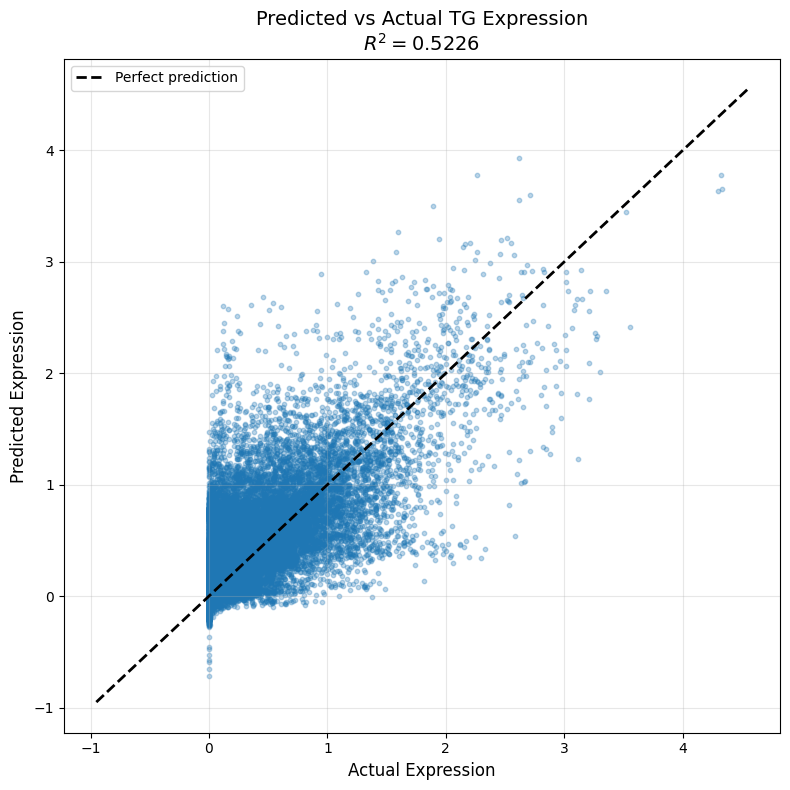

R² (all genes): 0.5226
N samples: 143040


In [28]:
# Add after metrics computation
import matplotlib.pyplot as plt

# Flatten for plotting
preds_flat = test_preds_np.flatten()
tgts_flat = test_tgts_np.flatten()

valid = np.isfinite(preds_flat) & np.isfinite(tgts_flat)
preds_clean = preds_flat[valid]
tgts_clean = tgts_flat[valid]

ss_res = np.sum((tgts_clean - preds_clean) ** 2)
ss_tot = np.sum((tgts_clean - np.mean(tgts_clean)) ** 2)
r2 = 1 - (ss_res / ss_tot)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tgts_clean, preds_clean, alpha=0.3, s=10)

lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k--', lw=2, label='Perfect prediction')

ax.set_xlabel('Actual Expression', fontsize=12)
ax.set_ylabel('Predicted Expression', fontsize=12)
ax.set_title(f'Predicted vs Actual TG Expression\n$R^2 = {r2:.4f}$', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"R² (all genes): {r2:.4f}")
print(f"N samples: {len(preds_clean)}")

Found checkpoints: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
Evaluating checkpoint_0.pt ...
Evaluating checkpoint_5.pt ...
Evaluating checkpoint_10.pt ...
Evaluating checkpoint_15.pt ...
Evaluating checkpoint_20.pt ...
Evaluating checkpoint_25.pt ...
Evaluating checkpoint_30.pt ...
Evaluating checkpoint_35.pt ...
Evaluating checkpoint_40.pt ...
Evaluating checkpoint_45.pt ...
Evaluating checkpoint_50.pt ...
Evaluating checkpoint_55.pt ...
Evaluating checkpoint_60.pt ...
Evaluating checkpoint_65.pt ...
Evaluating checkpoint_70.pt ...
Evaluating checkpoint_75.pt ...
Evaluating checkpoint_80.pt ...


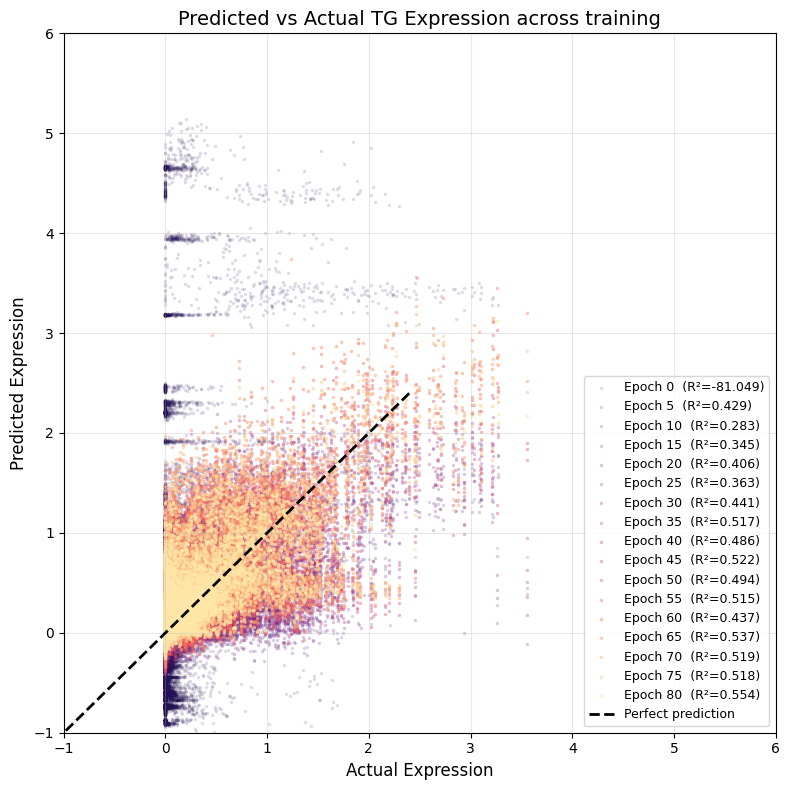

In [37]:
# ============================================================
# Evaluate multiple checkpoints and overlay Pred vs Actual plots
# ============================================================
import os, re, gc
import numpy as np
import torch
import matplotlib.pyplot as plt

# -------- CONFIG --------
CKPT_DIR = SELECTED_EXPERIMENT_DIR          # directory with checkpoint_*.pt
CKPT_GLOB_PREFIX = "checkpoint_"
CKPT_EXT = ".pt"
# If you want to select specific epochs, set this to a sorted list, e.g. [5, 10, 20, 50, 70].
# If None, we'll discover all checkpoints matching the pattern and sort by epoch.
EPOCHS_TO_PLOT = None

# Evaluation controls
NUM_TGS_SUBSET = 200       # same as your current eval
TG_BATCH_SIZE = 50
NUM_BATCHES_TO_EVAL = 5   # evaluate first N batches from test_loader
MAX_POINTS_TO_PLOT = 150_000  # for scatter downsampling per checkpoint to keep plot responsive

# Plot look
FIGSIZE = (8, 8)
CMAP = plt.cm.viridis       # any matplotlib colormap
BASE_ALPHA = 0.10           # base opacity for earliest checkpoint; grows with epoch
MARKER_SIZE = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def parse_epoch_from_filename(fname: str):
    m = re.search(rf"{CKPT_GLOB_PREFIX}(\d+){re.escape(CKPT_EXT)}$", fname)
    return int(m.group(1)) if m else None

def list_checkpoints(ckpt_dir):
    files = []
    for f in os.listdir(ckpt_dir):
        if f.startswith(CKPT_GLOB_PREFIX) and f.endswith(CKPT_EXT):
            ep = parse_epoch_from_filename(f)
            if ep is not None:
                files.append((ep, os.path.join(ckpt_dir, f)))
    files.sort(key=lambda x: x[0])
    if EPOCHS_TO_PLOT is not None:
        keep = set(EPOCHS_TO_PLOT)
        files = [(ep, p) for ep, p in files if ep in keep]
        files.sort(key=lambda x: x[0])
    return files

def evaluate_checkpoint(ckpt_path: str):
    """Returns flattened preds, tgts, and R^2 for the subset/batches specified."""
    # Load state
    state = torch.load(ckpt_path, map_location="cpu")

    # Recreate the model with the same hyperparams you already have in scope
    model = MultiomicTransformer(
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        d_ff=D_FF,
        dropout=DROPOUT,
        tf_vocab_size=len(state["tf_scaler_mean"]),
        tg_vocab_size=len(state["tg_scaler_mean"]),
        use_bias=USE_DISTANCE_BIAS,
        use_shortcut=USE_SHORTCUT,
        use_motif_mask=USE_MOTIF_MASK,
    )
    model.load_state_dict(state["model_state_dict"] if isinstance(state, dict) and "model_state_dict" in state else state)
    model.to(device).eval()

    # Scalers on device for fast denorm
    tg_scaler_mean = torch.as_tensor(state["tg_scaler_mean"], device=device, dtype=torch.float32)
    tg_scaler_std  = torch.as_tensor(state["tg_scaler_std"],  device=device, dtype=torch.float32)

    preds_all = []
    tgts_all = []

    use_amp = (device.type == "cuda")
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            if batch_idx >= NUM_BATCHES_TO_EVAL:
                break

            atac, tf, tg_target, bias, tf_ids, tg_ids, motif = batch
            atac = atac.to(device, non_blocking=True)
            tf = tf.to(device, non_blocking=True)
            tg_target = tg_target.to(device, non_blocking=True)
            tf_ids = tf_ids.to(device, non_blocking=True).long()
            tg_ids = tg_ids.to(device, non_blocking=True).long()

            batch_preds = []
            max_tgs = min(NUM_TGS_SUBSET, len(tg_ids))
            for tg_start in range(0, max_tgs, TG_BATCH_SIZE):
                tg_end = min(tg_start + TG_BATCH_SIZE, max_tgs)
                tg_ids_chunk = tg_ids[tg_start:tg_end]

                with torch.amp.autocast(device_type="cuda", enabled=use_amp):
                    preds, _ = model(atac, tf, tf_ids=tf_ids, tg_ids=tg_ids_chunk)

                # Denormalize: [B, tg_chunk] * [tg_chunk] + [tg_chunk]
                preds_denorm = preds * tg_scaler_std.index_select(0, tg_ids_chunk).unsqueeze(0) \
                                     + tg_scaler_mean.index_select(0, tg_ids_chunk).unsqueeze(0)
                batch_preds.append(preds_denorm.float().cpu())

            preds_full = torch.cat(batch_preds, dim=1).numpy()
            preds_all.append(preds_full)

            # match target width to preds
            tgts_all.append(tg_target[:, :preds_full.shape[1]].cpu().numpy())

    preds_np = np.concatenate(preds_all, axis=0)
    tgts_np  = np.concatenate(tgts_all, axis=0)

    # Compute R^2 on flattened, NaN-safe
    pf = preds_np.ravel()
    tfv = tgts_np.ravel()
    valid = np.isfinite(pf) & np.isfinite(tfv)
    if valid.sum() < 2 or np.all(tfv[valid] == tfv[valid].mean()):
        r2 = np.nan
    else:
        ss_res = np.sum((tfv[valid] - pf[valid]) ** 2)
        ss_tot = np.sum((tfv[valid] - tfv[valid].mean()) ** 2)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-12))

    # Optional cleanup
    del model, state, tg_scaler_mean, tg_scaler_std
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    return preds_np, tgts_np, r2

# ---------- Run across checkpoints ----------
ckpts = list_checkpoints(CKPT_DIR)
if len(ckpts) == 0:
    raise FileNotFoundError(f"No checkpoints found under {CKPT_DIR} matching pattern {CKPT_GLOB_PREFIX}*{CKPT_EXT}")

print("Found checkpoints:", [ep for ep, _ in ckpts])

all_layers = []  # list of dicts: {"epoch": ep, "preds": preds_np, "tgts": tgts_np, "r2": r2}
for ep, path in ckpts:
    print(f"Evaluating {os.path.basename(path)} ...")
    preds_np, tgts_np, r2 = evaluate_checkpoint(path)
    all_layers.append({"epoch": ep, "preds": preds_np, "tgts": tgts_np, "r2": r2})

# ---------- Plot overlay (magma + expanded limits) ----------
CMAP = plt.cm.magma  # magma colormap

fig, ax = plt.subplots(figsize=(8, 8))

# Global limits with extra padding
all_targets = np.concatenate([L["tgts"].ravel() for L in all_layers])
all_preds   = np.concatenate([L["preds"].ravel() for L in all_layers])
valid_all = np.isfinite(all_targets) & np.isfinite(all_preds)

low  = np.nanpercentile(np.concatenate([all_targets[valid_all], all_preds[valid_all]]), 0.5)
high = np.nanpercentile(np.concatenate([all_targets[valid_all], all_preds[valid_all]]), 99.5)
rng  = high - low
pad  = 0.25 * rng  # enlarge limits by 25%
lims = [low - pad, high + pad]

# Sort by epoch so later checkpoints draw last (and stand out)
all_layers.sort(key=lambda d: d["epoch"])
n_ckpts    = len(all_layers)
positions  = np.linspace(0.15, 0.95, n_ckpts)  # where to sample colors along magma

BASE_ALPHA = 0.15
MAX_ALPHA  = 0.60
MARKER_SIZE = 6
MAX_POINTS_TO_PLOT = 150_000

for i, layer in enumerate(all_layers):
    ep    = layer["epoch"]
    preds = layer["preds"].ravel()
    tgts  = layer["tgts"].ravel()
    valid = np.isfinite(preds) & np.isfinite(tgts)
    idx   = np.where(valid)[0]

    # Downsample for readability
    if len(idx) > MAX_POINTS_TO_PLOT:
        rng_ds = np.random.default_rng(1234 + i)
        idx = rng_ds.choice(idx, size=MAX_POINTS_TO_PLOT, replace=False)

    color = CMAP(positions[i])
    alpha = BASE_ALPHA + (MAX_ALPHA - BASE_ALPHA) * (i / max(1, n_ckpts - 1))

    ax.scatter(tgts[idx], preds[idx],
               s=MARKER_SIZE, c=[color], alpha=alpha, linewidths=0,
               label=f"Epoch {ep}  (R²={layer['r2']:.3f})")

# 1:1 line
ax.plot(lims, lims, linestyle="--", color="black", linewidth=2, label="Perfect prediction")

ax.set_xlim((-1, 6))
ax.set_ylim((-1,6))
ax.set_xlabel("Actual Expression", fontsize=12)
ax.set_ylabel("Predicted Expression", fontsize=12)
ax.set_title("Predicted vs Actual TG Expression across training", fontsize=14)
ax.grid(alpha=0.3)
ax.legend(loc="lower right", fontsize=9, frameon=True)
plt.tight_layout()
plt.show()


In [47]:
import os
import json
import numpy as np
from pathlib import Path

import torch
from torch.utils.data import DataLoader

from multiomic_transformer.scripts.train import prepare_dataloader
# Assumes these are already available in your environment:
# - MultiChromosomeDataset, MultiomicTransformer, SimpleScaler
# - SELECTED_EXPERIMENT_DIR, TRAINING_DATA_CACHE, D_MODEL, NUM_HEADS, NUM_LAYERS, D_FF, DROPOUT,
#   ATTN_BIAS_SCALE, USE_DISTANCE_BIAS, USE_SHORTCUT, USE_MOTIF_MASK, SHORTCUT_L1, SHORTCUT_L2,
#   SHORTCUT_TOPK, SHORTCUT_DROPOUT, BATCH_SIZE

# ============================================================================
# CONFIG
# ============================================================================
HOLDOUT_DIR = "data/training_data_cache/mESC_holdout"
COMMON_VOCAB_DIR = TRAINING_DATA_CACHE / "common"  # shared vocab folder for both datasets
CKPT_PATH   = os.path.join(SELECTED_EXPERIMENT_DIR, "checkpoint_5.pt")
DEVICE      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 4
probe_disable_mask_and_bias = False  # set True to test model without priors/bias

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def _std_name(n):
    """Mirror dataset normalization (uppercasing); add stripping/version removal if needed."""
    return str(n).upper()


def load_and_normalize_vocab(json_path):
    """Load vocab JSON and normalize keys for matching."""
    with open(json_path) as f:
        raw = json.load(f)  # {"GENE": idx}
    return {_std_name(k): int(v) for k, v in raw.items()}


def build_id_remap(hold2id: dict, ckpt2id: dict):
    """
    Build remapping from holdout IDs to checkpoint IDs.
    Returns (remap tensor, overlap count).
    
    remap[holdout_id] = checkpoint_id (or -1 if no match)
    """
    remap = torch.full((len(hold2id),), -1, dtype=torch.long)
    overlap = 0
    for name, hid in hold2id.items():
        if name in ckpt2id:
            remap[hid] = int(ckpt2id[name])
            overlap += 1
    return remap, overlap


def inverse_transform(scaler, x: torch.Tensor, ids: torch.Tensor) -> torch.Tensor:
    """
    Inverse transform (denormalize) using scaler stats.
    
    Args:
        scaler: SimpleScaler object with .mean and .std
        x: [B, G] normalized values
        ids: [G] indices into scaler mean/std (checkpoint space IDs)
    
    Returns:
        [B, G] denormalized values
    """
    device = x.device
    ids = ids.to(device)
    
    # Ensure scaler tensors are on the same device
    mu = scaler.mean.to(device).index_select(0, ids)
    sig = scaler.std.to(device).index_select(0, ids).clamp_min(1e-6)
    
    # Expand dims to broadcast with batch dimension
    while mu.dim() < x.dim():
        mu = mu.unsqueeze(0)
        sig = sig.unsqueeze(0)
    
    return x * sig + mu


def nanaware_per_gene_stats(y_true, y_pred, eps=1e-8):
    """
    Compute per-gene statistics accounting for NaN entries.
    
    Args:
        y_true: [N, G] with NaNs for missing entries
        y_pred: [N, G] with NaNs for missing entries
        eps: small constant for numerical stability
    
    Returns:
        dict with per-gene arrays of length G: r2, pearson, mae, rmse, n_obs
    """
    N, G = y_true.shape
    r2 = np.full(G, np.nan, dtype=np.float64)
    pearson = np.full(G, np.nan, dtype=np.float64)
    mae = np.full(G, np.nan, dtype=np.float64)
    rmse = np.full(G, np.nan, dtype=np.float64)
    n_obs = np.zeros(G, dtype=np.int32)

    for j in range(G):
        # Identify valid (finite) observations
        mask = np.isfinite(y_true[:, j]) & np.isfinite(y_pred[:, j])
        m = mask.sum()
        n_obs[j] = m
        
        if m < 2:
            # Need at least 2 points for correlation
            continue
            
        yt = y_true[mask, j].astype(np.float64)
        yp = y_pred[mask, j].astype(np.float64)

        # MAE / RMSE
        diff = yt - yp
        mae[j] = np.mean(np.abs(diff))
        rmse[j] = np.sqrt(np.mean(diff**2))

        # Pearson correlation (symmetric, invariant to scale/shift)
        yt_c = yt - yt.mean()
        yp_c = yp - yp.mean()
        yt_std = np.sqrt((yt_c**2).sum())
        yp_std = np.sqrt((yp_c**2).sum())
        if yt_std > 0 and yp_std > 0:
            pearson[j] = (yt_c @ yp_c) / (yt_std * yp_std)

        # Standard R² (unaltered means)
        # R² = 1 - SSE / SST, where SST = sum((y_true - mean(y_true))^2)
        sst = ((yt - yt.mean())**2).sum()
        sse = (diff**2).sum()
        r2[j] = 1.0 - sse / (sst + eps)

    return {
        "r2": r2,
        "pearson": pearson,
        "mae": mae,
        "rmse": rmse,
        "n_obs": n_obs,
    }


def check_distribution_shift(y_true, train_means, train_stds, all_ids):
    """
    Check for distribution shift between holdout and training.
    
    Args:
        y_true: [N, G_aligned] array (possibly with NaNs)
        train_means: [G_ckpt] array of training means (at checkpoint indices)
        train_stds: [G_ckpt] array of training stds
        all_ids: [G_aligned] checkpoint IDs for the aligned genes
    
    Returns:
        dict with diagnostics
    """
    hold_means = np.nanmean(y_true, axis=0)
    hold_stds = np.nanstd(y_true, axis=0)
    
    train_means_subset = train_means[all_ids]
    train_stds_subset = train_stds[all_ids]
    
    mean_shift = np.nanmedian(np.abs(hold_means - train_means_subset))
    std_ratio = np.nanmedian(hold_stds / (train_stds_subset + 1e-8))
    
    return {
        "median_mean_shift": float(mean_shift),
        "median_std_ratio": float(std_ratio),
        "hold_mean_min_max": (float(np.nanmin(hold_means)), float(np.nanmax(hold_means))),
        "train_mean_min_max": (float(np.nanmin(train_means_subset)), float(np.nanmax(train_means_subset))),
    }


# ============================================================================
# LOAD CHECKPOINT AND VERIFY SCALER STATE
# ============================================================================

print("[Loading checkpoint...]")
state = torch.load(CKPT_PATH, map_location=DEVICE)

# Verify required scaler tensors exist
required_scaler_keys = ["tf_scaler_mean", "tf_scaler_std", "tg_scaler_mean", "tg_scaler_std"]
for key in required_scaler_keys:
    if key not in state:
        raise ValueError(f"Checkpoint missing required key: {key}")

tf_scaler = type('SimpleScaler', (), {
    'mean': state["tf_scaler_mean"].to(DEVICE),
    'std': state["tf_scaler_std"].to(DEVICE)
})()

tg_scaler = type('SimpleScaler', (), {
    'mean': state["tg_scaler_mean"].to(DEVICE),
    'std': state["tg_scaler_std"].to(DEVICE)
})()

print(f"[Scaler] TF: {tf_scaler.mean.shape}, TG: {tg_scaler.mean.shape}")

# ============================================================================
# LOAD DATASET AND BUILD VOCAB REMAPPINGS
# ============================================================================

print("[Loading holdout dataset...]")

# 0) chrom ids from holdout dir
holdout_path = Path(HOLDOUT_DIR)
chrom_ids = sorted([p.name for p in holdout_path.iterdir() if p.is_dir()])
assert chrom_ids, f"No chromosome subdirectories found in {HOLDOUT_DIR}"

# 1) dataset with shared common vocabs
tf_vocab_path_arg = str(Path(COMMON_VOCAB_DIR) / "tf_vocab.json")
tg_vocab_path_arg = str(Path(COMMON_VOCAB_DIR) / "tg_vocab.json")
assert os.path.isfile(tf_vocab_path_arg), f"Missing TF vocab: {tf_vocab_path_arg}"
assert os.path.isfile(tg_vocab_path_arg), f"Missing TG vocab: {tg_vocab_path_arg}"

ds = MultiChromosomeDataset(
    data_dir=HOLDOUT_DIR,
    chrom_ids=chrom_ids,
    tf_vocab_path=tf_vocab_path_arg,
    tg_vocab_path=tg_vocab_path_arg,
    max_cached=2,
    max_tfs=None, max_tgs=None,
    max_windows_per_chrom=None, max_cells=None,
    subset_seed=None,
)

_, _, test_loader = prepare_dataloader(
    ds,
    batch_size=BATCH_SIZE,
    world_size=1,
    rank=0,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    seed=42,
    drop_last=False,
)

# 2) checkpoint vocabs define model sizes
ckpt_tf2id = load_and_normalize_vocab(os.path.join(SELECTED_EXPERIMENT_DIR, "tf_vocab.json"))
ckpt_tg2id = load_and_normalize_vocab(os.path.join(SELECTED_EXPERIMENT_DIR, "tg_vocab.json"))
T_ckpt = len(ckpt_tf2id)
G_ckpt = len(ckpt_tg2id)

# Verify scaler matches checkpoint vocab size
assert tf_scaler.mean.shape[0] == T_ckpt, \
    f"TF scaler size {tf_scaler.mean.shape[0]} != checkpoint vocab {T_ckpt}"
assert tg_scaler.mean.shape[0] == G_ckpt, \
    f"TG scaler size {tg_scaler.mean.shape[0]} != checkpoint vocab {G_ckpt}"

# 3) holdout name→id maps (normalize keys for matching)
hold_tf2id = {_std_name(k): int(v) for k, v in ds.tf_name2id_sub.items()}
hold_tg2id = {_std_name(k): int(v) for k, v in ds.tg_name2id_sub.items()}

tf_hold2ckpt, tf_overlap = build_id_remap(hold_tf2id, ckpt_tf2id)
tg_hold2ckpt, tg_overlap = build_id_remap(hold_tg2id, ckpt_tg2id)

print(f"[Vocab] TF overlap: {tf_overlap} / holdout_TF={len(hold_tf2id)} / ckpt_TF={T_ckpt}")
print(f"[Vocab] TG overlap: {tg_overlap} / holdout_TG={len(hold_tg2id)} / ckpt_TG={G_ckpt}")

if tf_overlap == 0 or tg_overlap == 0:
    print("[Warning] Zero overlap detected. Results may be meaningless.")

# ============================================================================
# LOAD MODEL
# ============================================================================

print("[Loading model...]")

model = MultiomicTransformer(
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    d_ff=D_FF,
    dropout=DROPOUT,
    tf_vocab_size=T_ckpt,
    tg_vocab_size=G_ckpt,
    bias_scale=ATTN_BIAS_SCALE,
    use_bias=USE_DISTANCE_BIAS,
    use_shortcut=USE_SHORTCUT,
    use_motif_mask=USE_MOTIF_MASK,
    lambda_l1=SHORTCUT_L1,
    lambda_l2=SHORTCUT_L2,
    topk=SHORTCUT_TOPK,
    shortcut_dropout=SHORTCUT_DROPOUT,
).to(DEVICE)

if isinstance(state, dict) and "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)

model.eval()
print("[Model] Loaded and set to eval mode")

# ============================================================================
# PRECOMPUTE REMAPPING TENSORS ON DEVICE
# ============================================================================

tf_hold2ckpt = tf_hold2ckpt.to(DEVICE)
tg_hold2ckpt = tg_hold2ckpt.to(DEVICE)
all_ckpt_tf_ids = torch.arange(T_ckpt, device=DEVICE, dtype=torch.long)

# ============================================================================
# INFERENCE LOOP
# ============================================================================

print("[Starting inference...]")

batch_preds, batch_tgts, batch_ids = [], [], []
batches_skipped = 0

with torch.no_grad():
    for b_ix, batch in enumerate(test_loader):
        (atac_wins,
         tf_tensor,   # [B, T_hold]
         targets,     # [B, G_batch]
         bias,        # [B, G_batch, W] or [B, 1, G_batch, W] or None
         tf_ids,      # [T_hold] or [B, T_hold]
         tg_ids,      # [G_batch] or [B, G_batch]
         motif_mask)  = batch

        atac_wins  = atac_wins.to(DEVICE)
        tf_tensor  = tf_tensor.to(DEVICE)
        targets    = targets.to(DEVICE)
        bias       = None if (probe_disable_mask_and_bias or bias is None) else bias.to(DEVICE)
        tg_ids     = tg_ids.to(DEVICE)
        motif_mask = None if (probe_disable_mask_and_bias or motif_mask is None) else motif_mask.to(DEVICE)

        # Handle batch-dimension issues
        if tg_ids.dim() == 2:
            tg_ids = tg_ids[0]
        if tf_ids is not None and tf_ids.dim() == 2:
            tf_ids = tf_ids[0]

        B, T_hold = tf_tensor.shape

        # ====================================================================
        # EXPAND TFs TO CHECKPOINT SPACE
        # ====================================================================
        
        tf_in_full = torch.zeros(B, T_ckpt, device=DEVICE, dtype=tf_tensor.dtype)
        valid_tf = (tf_hold2ckpt >= 0)
        
        if valid_tf.any():
            src_idx = torch.nonzero(valid_tf, as_tuple=True)[0]
            dst_idx = tf_hold2ckpt[valid_tf]
            tf_in_full[:, dst_idx] = tf_tensor[:, src_idx]

        # Diagnostic: TF coverage
        nz_cols = (tf_in_full.abs().sum(dim=0) > 0).float().mean().item()
        if b_ix == 0 or b_ix % 10 == 0:
            print(f"[Batch {b_ix}] TF non-zero column fraction: {nz_cols:.3f}")

        # ====================================================================
        # SCALE TFs (with assertion for safety)
        # ====================================================================
        
        assert all_ckpt_tf_ids.shape[0] == tf_in_full.shape[1], \
            f"TF ID count {all_ckpt_tf_ids.shape[0]} != input TF columns {tf_in_full.shape[1]}"
        assert all_ckpt_tf_ids.max() < tf_scaler.mean.shape[0], \
            f"TF index {all_ckpt_tf_ids.max()} out of scaler range {tf_scaler.mean.shape[0]}"
        
        # Manually scale instead of calling a method (for clarity)
        tf_means = tf_scaler.mean.index_select(0, all_ckpt_tf_ids)
        tf_stds = tf_scaler.std.index_select(0, all_ckpt_tf_ids).clamp_min(1e-6)
        tf_in_full = (tf_in_full - tf_means.unsqueeze(0)) / tf_stds.unsqueeze(0)

        # ====================================================================
        # REMAP TGs AND FILTER TO OVERLAPPING GENES
        # ====================================================================
        
        tg_ckpt_ids = tg_hold2ckpt[tg_ids]  # [-1] where no overlap
        keep_rows = tg_ckpt_ids >= 0
        
        if keep_rows.sum() == 0:
            print(f"[Batch {b_ix}] Warning: No TG overlap. Skipping {targets.shape[1]} genes.")
            batches_skipped += 1
            continue

        tg_ckpt_ids = tg_ckpt_ids[keep_rows]      # [G_keep]
        targets_kept = targets[:, keep_rows]      # [B, G_keep]

        # ====================================================================
        # SLICE BIAS TO MATCH KEPT TG ROWS
        # ====================================================================
        
        if bias is not None:
            expected_g_dim_size = keep_rows.sum().item()
            
            if bias.dim() == 3:
                # [B, G_batch, W]
                assert bias.shape[1] == targets.shape[1], \
                    f"Bias TG dim {bias.shape[1]} != targets TG dim {targets.shape[1]}"
                bias = bias[:, keep_rows, :]  # [B, G_keep, W]
                
            elif bias.dim() == 4:
                # [B, H, G_batch, W] (one bias per attention head, or heads=1)
                assert bias.shape[2] == targets.shape[1], \
                    f"Bias TG dim {bias.shape[2]} != targets TG dim {targets.shape[1]}"
                bias = bias[:, :, keep_rows, :]  # [B, H, G_keep, W]
                
            else:
                raise RuntimeError(
                    f"Unexpected bias shape {tuple(bias.shape)}. Expected 3D [B, G, W] or 4D [B, H, G, W]"
                )

        # ====================================================================
        # EXPAND MOTIF MASK AND SLICE ROWS
        # ====================================================================
        
        motif_mask_full = None
        
        if motif_mask is not None and motif_mask.numel() > 0:
            # Handle batch dimension if present
            if motif_mask.dim() == 3:
                # [B, G, T] or similar; collapse batch (assume same for all in batch)
                motif_mask = motif_mask[0]
            
            G_batch_motif, T_hold_m = motif_mask.shape
            
            # Safety checks
            assert T_hold_m == T_hold, \
                f"Motif mask TF dimension {T_hold_m} != tf_tensor TF dimension {T_hold}"
            assert G_batch_motif == targets.shape[1], \
                f"Motif mask TG dimension {G_batch_motif} != targets TG dimension {targets.shape[1]}"
            
            # Expand columns (TF dimension) to checkpoint space
            mm_full = torch.zeros(G_batch_motif, T_ckpt, device=DEVICE, dtype=motif_mask.dtype)
            valid_tf = (tf_hold2ckpt >= 0)
            if valid_tf.any():
                src_idx = torch.nonzero(valid_tf, as_tuple=True)[0]
                dst_idx = tf_hold2ckpt[valid_tf]
                mm_full[:, dst_idx] = motif_mask[:, src_idx]
            
            # Slice rows (TG dimension) to matched genes
            motif_mask_full = mm_full[keep_rows]  # [G_keep, T_ckpt]

        # ====================================================================
        # FORWARD PASS
        # ====================================================================
        
        preds_scaled, attn_out = model(
            atac_wins,
            tf_in_full,
            tf_ids=all_ckpt_tf_ids,
            tg_ids=tg_ckpt_ids,
            bias=bias,
            motif_mask=motif_mask_full if USE_MOTIF_MASK else None,
        )

        # ====================================================================
        # INVERSE TRANSFORM (DENORMALIZE)
        # ====================================================================
        
        preds = inverse_transform(tg_scaler, preds_scaled, ids=tg_ckpt_ids)  # [B, G_keep]

        # ====================================================================
        # CACHE OUTPUTS FOR POST-HOC ALIGNMENT
        # ====================================================================
        
        batch_preds.append(preds.cpu().numpy())
        batch_tgts.append(targets_kept.cpu().numpy())
        batch_ids.append(tg_ckpt_ids.cpu().numpy())

print(f"[Inference complete] Processed {b_ix + 1} batches, skipped {batches_skipped}")

# ============================================================================
# POST-HOC ALIGNMENT: UNIFY TG COLUMNS ACROSS BATCHES
# ============================================================================

if not batch_preds:
    raise RuntimeError(
        "No usable batches after remapping; check vocab overlap between holdout and checkpoint."
    )

print("[Building aligned data matrix...]")

# Global TG order (sorted unique checkpoint IDs observed)
all_ids = np.unique(np.concatenate(batch_ids))
G_all = len(all_ids)
id2pos = {g: i for i, g in enumerate(all_ids)}

# Build aligned matrices (NaN where a batch doesn't contain a TG)
aligned_preds = []
aligned_tgts = []

for batch_ix, (preds_i, tgts_i, ids_i) in enumerate(zip(batch_preds, batch_tgts, batch_ids)):
    B_i, G_i = preds_i.shape
    P_full = np.full((B_i, G_all), np.nan, dtype=preds_i.dtype)
    T_full = np.full((B_i, G_all), np.nan, dtype=tgts_i.dtype)
    
    cols = [id2pos[g] for g in ids_i]
    P_full[:, cols] = preds_i
    T_full[:, cols] = tgts_i
    
    aligned_preds.append(P_full)
    aligned_tgts.append(T_full)

preds_np = np.concatenate(aligned_preds, axis=0)  # [N, G_all]
tgts_np = np.concatenate(aligned_tgts, axis=0)    # [N, G_all]

print(f"[Aligned matrix] Shape: {preds_np.shape}")

# ============================================================================
# DIAGNOSTICS: BASIC STATISTICS
# ============================================================================

print("\n" + "="*70)
print("DIAGNOSTICS: Original Space")
print("="*70)

var_true = np.nanvar(tgts_np, axis=0)
mean_true = np.nanmean(tgts_np, axis=0)
mean_pred = np.nanmean(preds_np, axis=0)
mean_bias = mean_pred - mean_true

n_low_var_genes = int((var_true < 1e-6).sum())
median_mean_bias = float(np.nanmedian(np.abs(mean_bias)))

print(f"Genes with very low variance (<1e-6): {n_low_var_genes} / {G_all}")
print(f"Median |mean_pred - mean_true|: {median_mean_bias:.6f}")

# Check for distribution shift
tg_means_ckpt = state["tg_scaler_mean"].cpu().numpy()[all_ids]
tg_stds_ckpt = np.clip(state["tg_scaler_std"].cpu().numpy()[all_ids], 1e-6, None)
hold_means = np.nanmean(tgts_np, axis=0)

median_diff_from_training = float(np.nanmedian(np.abs(hold_means - tg_means_ckpt)))
print(f"Median |holdout_mean - training_mean|: {median_diff_from_training:.6f}")

shift_diags = check_distribution_shift(tgts_np, 
                                        state["tg_scaler_mean"].cpu().numpy(),
                                        state["tg_scaler_std"].cpu().numpy(),
                                        all_ids)
print(f"\nDistribution Shift Diagnostics:")
print(f"  Median mean shift: {shift_diags['median_mean_shift']:.6f}")
print(f"  Median std ratio (holdout/train): {shift_diags['median_std_ratio']:.4f}")
print(f"  Holdout mean range: [{shift_diags['hold_mean_min_max'][0]:.4f}, {shift_diags['hold_mean_min_max'][1]:.4f}]")
print(f"  Training mean range: [{shift_diags['train_mean_min_max'][0]:.4f}, {shift_diags['train_mean_min_max'][1]:.4f}]")

# ============================================================================
# METRICS: ORIGINAL SPACE
# ============================================================================

print("\n" + "="*70)
print("METRICS: Original Space")
print("="*70)

stats = nanaware_per_gene_stats(tgts_np, preds_np)

r2_valid = stats["r2"][np.isfinite(stats["r2"])]
pearson_valid = stats["pearson"][np.isfinite(stats["pearson"])]
mae_valid = stats["mae"][np.isfinite(stats["mae"])]
rmse_valid = stats["rmse"][np.isfinite(stats["rmse"])]

print(f"R²:        mean={np.nanmean(stats['r2']):.4f}  median={np.nanmedian(stats['r2']):.4f}  "
      f"min={np.nanmin(stats['r2']):.4f}  max={np.nanmax(stats['r2']):.4f}")
print(f"Pearson ρ: mean={np.nanmean(stats['pearson']):.4f}  median={np.nanmedian(stats['pearson']):.4f}")
print(f"MAE:       median={np.nanmedian(stats['mae']):.6f}  mean={np.nanmean(stats['mae']):.6f}")
print(f"RMSE:      median={np.nanmedian(stats['rmse']):.6f}  mean={np.nanmean(stats['rmse']):.6f}")

n_genes_5obs = int((stats["n_obs"] >= 5).sum())
print(f"Genes with ≥5 observations: {n_genes_5obs} / {G_all}")

# ============================================================================
# METRICS: SCALED SPACE (removes unit/mean/variance mismatches)
# ============================================================================

print("\n" + "="*70)
print("METRICS: Scaled Space (standardized)")
print("="*70)

# Standardize both true and pred by training statistics
tgts_scaled = (tgts_np - tg_means_ckpt[None, :]) / tg_stds_ckpt[None, :]
preds_scaled_re = (preds_np - tg_means_ckpt[None, :]) / tg_stds_ckpt[None, :]

stats_scaled = nanaware_per_gene_stats(tgts_scaled, preds_scaled_re)

print(f"R² (scaled):        mean={np.nanmean(stats_scaled['r2']):.4f}  median={np.nanmedian(stats_scaled['r2']):.4f}")
print(f"Pearson ρ (scaled): mean={np.nanmean(stats_scaled['pearson']):.4f}  median={np.nanmedian(stats_scaled['pearson']):.4f}")
print(f"MAE (scaled):       median={np.nanmedian(stats_scaled['mae']):.6f}")
print(f"RMSE (scaled):      median={np.nanmedian(stats_scaled['rmse']):.6f}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Holdout unique TGs evaluated (checkpoint space): {G_all}")
print(f"TG vocab overlap: {tg_overlap / len(hold_tg2id) * 100:.1f}% ({tg_overlap} / {len(hold_tg2id)})")
print(f"TF vocab overlap: {tf_overlap / len(hold_tf2id) * 100:.1f}% ({tf_overlap} / {len(hold_tf2id)})")
print(f"Model: USE_MOTIF_MASK={USE_MOTIF_MASK}, USE_DISTANCE_BIAS={USE_DISTANCE_BIAS}, USE_SHORTCUT={USE_SHORTCUT}")
print(f"Device: {DEVICE}")
print("="*70)

[Loading checkpoint...]


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC_no_scale_linear/chr19/model_training_046/checkpoint_5.pt'

## TF-TG Embedding Similarity

In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list


def plot_dense_tf_tg_heatmap(
    emb_path,
    vocab_path,
    tf_indices=None,
    tg_indices=None,
    max_tf=300,
    max_tg=600,
    row_zscore=True,
    cmap="viridis",
):
    """
    Plot a dense TF × TG cosine similarity heatmap for a subset of embeddings.

    - Computes cosine(tf_emb, tg_emb) for chosen TF/TG indices
    - Optionally row-wise z-scores (default: True) so TF-specific high sims stand out
    - Hierarchically clusters rows & columns for block structure
    """

    # ---- Load embeddings & vocab ----
    emb = torch.load(emb_path, map_location="cpu")
    tf_emb = emb["tf_emb"]          # [T, D]
    tg_emb = emb["tg_emb"]          # [G, D] or "tg_query_emb"

    id2name = torch.load(vocab_path, map_location="cpu")
    tf_names_full = id2name.get("tf_id2name", [f"TF_{i}" for i in range(tf_emb.shape[0])])
    tg_names_full = id2name.get("tg_id2name", [f"TG_{i}" for i in range(tg_emb.shape[0])])

    T = tf_emb.shape[0]
    G = tg_emb.shape[0]

    # ---- Choose subset ----
    if tf_indices is None:
        tf_indices = list(range(min(max_tf, T)))
    if tg_indices is None:
        tg_indices = list(range(min(max_tg, G)))

    # ---- Cosine similarity ----
    tf_norm = F.normalize(tf_emb[tf_indices], p=2, dim=1)      # [T_sub, D]
    tg_norm = F.normalize(tg_emb[tg_indices], p=2, dim=1)      # [G_sub, D]
    sim_sub = (tf_norm @ tg_norm.T).detach().cpu().numpy()     # [T_sub, G_sub]

    tf_labels = [tf_names_full[i] for i in tf_indices]
    tg_labels = [tg_names_full[j] for j in tg_indices]

    # ---- Optional row-wise z-score (highlights TF-specific preferences) ----
    if row_zscore:
        row_mean = sim_sub.mean(axis=1, keepdims=True)
        row_std = sim_sub.std(axis=1, keepdims=True) + 1e-6
        X = (sim_sub - row_mean) / row_std
        cbar_label = "Row-wise z-scored cosine similarity"
    else:
        X = sim_sub
        cbar_label = "Cosine similarity"

    # ---- Hierarchical clustering (rows & columns) ----
    # Use Euclidean over X and X.T to group similar profiles
    row_link = linkage(X,   method="average", metric="euclidean")
    col_link = linkage(X.T, method="average", metric="euclidean")

    row_order = leaves_list(row_link)
    col_order = leaves_list(col_link)

    X_re = X[row_order][:, col_order]
    tf_labels_re = [tf_labels[i] for i in row_order]
    tg_labels_re = [tg_labels[j] for j in col_order]

    n_tf, n_tg = X_re.shape

    # ---- Figure sizing ----
    # Scale size with matrix but clamp to something sane for screens/papers.
    fig_w = max(8, min(20, n_tg * 0.015))
    fig_h = max(6, min(20, n_tf * 0.02))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    # ---- Color limits: focus on informative range of X_re ----
    low_p, high_p = np.percentile(X_re, [5, 95])
    im = ax.imshow(X_re, aspect="auto", cmap=cmap, vmin=low_p, vmax=high_p)

    # ---- Tick label logic (adaptive density & fontsize) ----
    max_labels = 40  # max ticks we’ll show per axis to avoid clutter

    # y-axis (TFs)
    if n_tf <= max_labels:
        y_idx = np.arange(n_tf)
    else:
        step = max(1, n_tf // max_labels)
        y_idx = np.arange(0, n_tf, step)
    ax.set_yticks(y_idx)
    ax.get_yaxis().set_ticks([])

    # x-axis (TGs)
    if n_tg <= max_labels:
        x_idx = np.arange(n_tg)
    else:
        step = max(1, n_tg // max_labels)
        x_idx = np.arange(0, n_tg, step)
    ax.set_xticks(x_idx)
    ax.get_xaxis().set_ticks([])

    ax.set_xlabel("Target genes", fontsize=16)
    ax.set_ylabel("Transcription factors", fontsize=16)
    ax.set_title(
        "TF–TG Cosine Similarity Heatmap",
        fontsize=18,
        pad=10,
    )

    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label, fontsize=12)

    plt.tight_layout()
    return fig

fig = plot_dense_tf_tg_heatmap(
    emb_path=SELECTED_EXPERIMENT_DIR / "tf_tg_embeddings.pt",
    vocab_path=SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt",
    max_tf=625,
    max_tg=6852,
)
fig.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_cos_sim_heatmap.png", dpi=200)
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC_no_scale_linear/chr19/model_training_049/tf_tg_embeddings.pt'

tf_tg_cos_sim_df
       source_id  0610005C13RIK  0610009E02RIK  0610030E20RIK  1110002J07RIK  \
0  2810021J22RIK       1.153610      -0.300309       0.779577       0.018354   
1  4930522L14RIK       1.774865       0.598426       1.266742       0.333425   
2          AEBP2       0.274961       0.629868       1.077932       0.353613   
3            AHR      -0.160730      -1.966216      -0.643560      -0.042274   
4           AHRR      -0.134230       1.994624       0.188494      -0.647251   

   1110019D14RIK  1110038F14RIK  1110046J04RIK  1110059E24RIK  1110059G10RIK  \
0      -1.532588       1.286276       1.378162       0.016168       0.736868   
1      -0.120766       1.030226       0.303140       0.974882      -1.423389   
2      -0.040284       0.043805      -1.729478       0.083839      -1.066579   
3      -0.566900       0.203480       1.386970      -1.125282      -0.846227   
4      -0.034015       1.466322       0.350502       0.997894       0.535892   

   ...    ZSCAN2   ZS

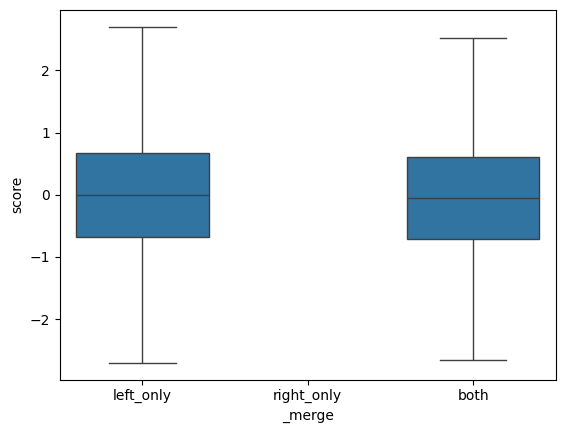

In [17]:
import seaborn as sns

# ---- Load ----
emb = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_embeddings.pt", map_location="cpu")
tf_emb = emb["tf_emb"]          # [T, D]
tg_emb = emb["tg_emb"]          # [G, D]  # or "tg_query_emb"

id2name = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt", map_location="cpu")
tf_names_full = id2name.get("tf_id2name", [f"TF_{i}" for i in range(tf_emb.shape[0])])
tg_names_full = id2name.get("tg_id2name", [f"TG_{i}" for i in range(tg_emb.shape[0])])

T = tf_emb.shape[0]
G = tg_emb.shape[0]

tf_emb = tf_emb[:T]
tg_emb = tg_emb[:G]
tf_names = tf_names_full[:T]
tg_names = tg_names_full[:G]

# ---- Cosine similarity ----
tf_norm = F.normalize(tf_emb, p=2, dim=1)       # [T, D]
tg_norm = F.normalize(tg_emb, p=2, dim=1)       # [G, D]
sim = (tf_norm @ tg_norm.T).cpu().numpy()       # [T, G]

mu = sim.mean(axis=1, keepdims=True)
sigma = sim.std(axis=1, keepdims=True) + 1e-6
z = (sim - mu) / sigma

tf_tg_cos_sim_df = pd.DataFrame(data=z, columns=tg_names, index=tf_names).reset_index().rename(columns={"index": "source_id"})
print('tf_tg_cos_sim_df')
print(tf_tg_cos_sim_df.head())

tf_tg_sim_melted = tf_tg_cos_sim_df.melt(id_vars="source_id", var_name="target_id", value_name="score")
print('\ntf_tg_sim_melted')
print(tf_tg_sim_melted.head())

kegg_graph_df = pd.read_csv("data/prior_knowledge_network_data/mm10/KEGG/kegg_mouse_pkn.csv")
print('\nkegg_graph_df')
print(kegg_graph_df.head())

k_nodes = set(kegg_graph_df["source_id"]) | set(kegg_graph_df["target_id"])

tf_tg_sim_kegg_merged = pd.merge(tf_tg_sim_melted, kegg_graph_df, on=["source_id", "target_id"], how="outer", indicator=True)
tf_tg_sim_kegg_merged = tf_tg_sim_kegg_merged[["source_id", "target_id", "score", "_merge"]]
tf_tg_sim_kegg_merged = tf_tg_sim_kegg_merged[
    (tf_tg_sim_kegg_merged["_merge"] == "left_only") | (tf_tg_sim_kegg_merged["_merge"] == "both")
    ]
print('\ntf_tg_sim_kegg_merged')
print(tf_tg_sim_kegg_merged.head())
print(tf_tg_sim_kegg_merged.shape)


edge_not_in_kegg = tf_tg_sim_kegg_merged[tf_tg_sim_kegg_merged["_merge"] == "left_only"]
edge_in_kegg = tf_tg_sim_kegg_merged[tf_tg_sim_kegg_merged["_merge"] == "both"]

sns.boxplot(data=tf_tg_sim_kegg_merged, x="_merge", y="score", showfliers=False)
plt.show()

In [18]:
print("Edges in KEGG:")
print(f"  - TFs: {edge_in_kegg['source_id'].nunique()}")
print(f"  - TGs: {edge_in_kegg['target_id'].nunique()}")
print(f"  - Avg Score: {edge_in_kegg['score'].mean():.4f}")

print("\nEdges NOT in KEGG:")
print(f"  - TFs: {edge_not_in_kegg['source_id'].nunique()}")
print(f"  - TGs: {edge_not_in_kegg['target_id'].nunique()}")
print(f"  - Avg Score: {edge_not_in_kegg['score'].mean():.4f}")

Edges in KEGG:
  - TFs: 103
  - TGs: 373
  - Avg Score: -0.0678

Edges NOT in KEGG:
  - TFs: 625
  - TGs: 6852
  - Avg Score: 0.0000


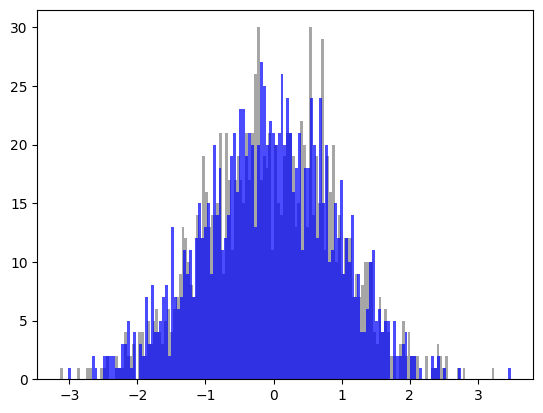

In [19]:
plt.hist(x=edge_not_in_kegg['score'].sample(n=len(edge_in_kegg)), bins=150, color='grey', alpha=0.7)
plt.hist(x=edge_in_kegg['score'], bins=150, color='blue', alpha=0.7)
plt.show()

In [143]:
k_nodes = set(kegg_graph_df["source_id"]) | set(kegg_graph_df["target_id"])
mask = tf_tg_sim_melted["source_id"].isin(k_nodes) & tf_tg_sim_melted["target_id"].isin(k_nodes)
univ = tf_tg_sim_melted[mask]

merged = pd.merge(
    univ,
    kegg_graph_df[["source_id", "target_id"]],
    on=["source_id", "target_id"],
    how="left",
    indicator=True
)
merged["label"] = (merged["_merge"] == "both").astype(int)


In [144]:
edge_not_in_kegg = tf_tg_sim_kegg_merged.query('_merge == "left_only"')["score"]
edge_in_kegg     = tf_tg_sim_kegg_merged.query('_merge == "both"')["score"]

print("Non-KEGG edges:", edge_not_in_kegg.describe())
print("KEGG edges:    ", edge_in_kegg.describe())

from scipy.stats import mannwhitneyu
u, p = mannwhitneyu(edge_in_kegg, edge_not_in_kegg, alternative="greater")
print("Mann-Whitney U (KEGG > non-KEGG):", u, "p =", p)

Non-KEGG edges: count    4.281307e+06
mean    -3.173193e-05
std      9.999797e-01
min     -4.602906e+00
25%     -6.656263e-01
50%     -1.778479e-02
75%      6.332563e-01
max      9.920693e+00
Name: score, dtype: float64
KEGG edges:     count    1193.000000
mean        0.113876
std         1.011695
min        -3.252104
25%        -0.574524
50%         0.091152
75%         0.739830
max         4.909314
Name: score, dtype: float64


Mann-Whitney U (KEGG > non-KEGG): 2718692904.0 p = 5.618183721645485e-05


_merge
left_only     0.9996
both          0.0004
right_only    0.0000
Name: proportion, dtype: float64


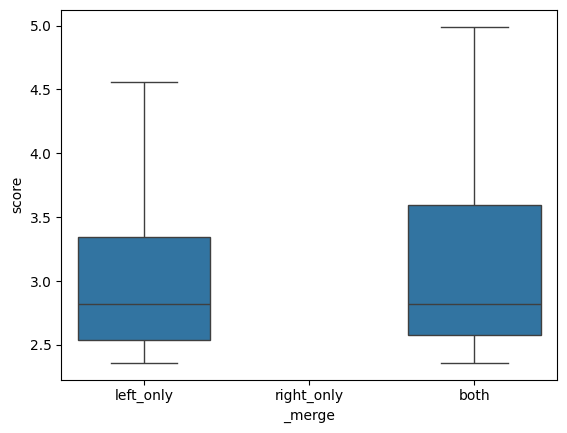

In [14]:
topN = 50000
top_edges = tf_tg_sim_kegg_merged.nlargest(topN, "score")

print(top_edges["_merge"].value_counts(normalize=True))
sns.boxplot(data=top_edges, x="_merge", y="score", showfliers=False)
plt.show()


In [15]:
all_frac_kegg = (tf_tg_sim_kegg_merged["_merge"] == "both").mean()
top_frac_kegg = (top_edges["_merge"] == "both").mean()
print("KEGG fraction overall:", all_frac_kegg)
print("KEGG fraction in topN:", top_frac_kegg)


KEGG fraction overall: 0.00027857559836544073
KEGG fraction in topN: 0.0004


In [20]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform


def extract_tf_tg_modules_clustered(
    emb_path,
    vocab_path,
    max_tf=None,
    max_tg=None,
    n_tf_clusters=15,
    tf_min_per_module=2,
    tg_min_per_module=15,
    tg_mean_z_thresh=1.0,
    tg_support_frac=0.2,
):
    """
    Extract TF–TG regulatory modules from embedding similarities using:
      - cosine(tf, tg)
      - row-wise z-score (per TF)
      - hierarchical clustering of TFs
      - cluster-specific TG selection

    Args:
      max_tf, max_tg: optionally limit #TF/#TG used.
      n_tf_clusters: number of TF clusters (modules candidates).
      tf_min_per_module: min TFs per module.
      tg_min_per_module: min TGs per module.
      tg_mean_z_thresh: min mean z-score across TFs in a cluster
                        for a TG to be included.
      tg_support_frac: min fraction of TFs in cluster with z>=1.0
                       for that TG (robustness).
    Returns:
      list of dicts: { "tfs": [...], "tgs": [...],
                       "size_tfs": int, "size_tgs": int }
    """

    # ---- Load ----
    emb = torch.load(emb_path, map_location="cpu")
    tf_emb = emb["tf_emb"]          # [T, D]
    tg_emb = emb["tg_emb"]          # [G, D]

    id2name = torch.load(vocab_path, map_location="cpu")
    tf_names_full = id2name.get("tf_id2name", [f"TF_{i}" for i in range(tf_emb.shape[0])])
    tg_names_full = id2name.get("tg_id2name", [f"TG_{i}" for i in range(tg_emb.shape[0])])

    T_tot, _ = tf_emb.shape
    G_tot, _ = tg_emb.shape

    if max_tf is None:
        max_tf = T_tot
    if max_tg is None:
        max_tg = G_tot

    T = min(T_tot, int(max_tf))
    G = min(G_tot, int(max_tg))

    tf_emb = tf_emb[:T]
    tg_emb = tg_emb[:G]
    tf_names = tf_names_full[:T]
    tg_names = tg_names_full[:G]

    # ---- Cosine similarity TF x TG ----
    tf_norm = F.normalize(tf_emb, p=2, dim=1)
    tg_norm = F.normalize(tg_emb, p=2, dim=1)
    sim = (tf_norm @ tg_norm.T).cpu().numpy()   # [T, G]

    # ---- Row-wise z-score (per TF) ----
    mu = sim.mean(axis=1, keepdims=True)
    sigma = sim.std(axis=1, keepdims=True) + 1e-6
    z = (sim - mu) / sigma                      # [T, G]

    # ---- Cluster TFs by similarity of their z-profiles ----
    # distance = 1 - corr, clipped to [0,2] for numerical sanity
    corr = np.corrcoef(z)
    dist = 1.0 - corr
    dist = np.clip(dist, 0.0, 2.0)

    # convert full distance matrix to condensed form
    Y = squareform(dist, checks=False)
    Z_link = linkage(Y, method="average")
    tf_cluster_labels = fcluster(Z_link, t=n_tf_clusters, criterion="maxclust")

    modules = []
    for c in np.unique(tf_cluster_labels):
        tf_idx = np.where(tf_cluster_labels == c)[0]
        if len(tf_idx) < tf_min_per_module:
            continue

        # z-scores for TFs in this cluster: [n_tf_c, G]
        z_sub = z[tf_idx, :]

        # mean z across TFs for each TG
        mean_z = z_sub.mean(axis=0)

        # fraction of TFs with z >= 1.0 for each TG
        support = (z_sub >= 1.0).mean(axis=0)

        # TGs that are consistently high for this cluster
        tg_idx = np.where(
            (mean_z >= tg_mean_z_thresh) & (support >= tg_support_frac)
        )[0]

        if len(tg_idx) < tg_min_per_module:
            continue

        mod_tfs = [tf_names[i] for i in tf_idx]
        mod_tgs = [tg_names[j] for j in tg_idx]

        modules.append(
            {
                "tfs": mod_tfs,
                "tgs": mod_tgs,
                "size_tfs": len(mod_tfs),
                "size_tgs": len(mod_tgs),
            }
        )

    # sort modules by "mass"
    modules.sort(key=lambda m: m["size_tfs"] * m["size_tgs"], reverse=True)
    return modules

modules = extract_tf_tg_modules_clustered(
    emb_path=SELECTED_EXPERIMENT_DIR / "tf_tg_embeddings.pt",
    vocab_path=SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt",
    max_tf=625,
    max_tg=6852,
    n_tf_clusters=15,      # try 10–30
    tf_min_per_module=2,
    tg_min_per_module=20,
    tg_mean_z_thresh=1.0,  # raise to 1.5 for stricter modules
    tg_support_frac=0.25,  # TG must be high for >=25% of TFs in cluster
)

print(f"Found {len(modules)} modules.")
for k, m in enumerate(modules[:5], 1):
    print(f"\nModule {k}: {m['size_tfs']} TFs, {m['size_tgs']} TGs")
    print("  TFs:", ", ".join(m["tfs"][:10]))
    print("  TGs (first 15):", ", ".join(m["tgs"][:10]), "...")


Found 0 modules.


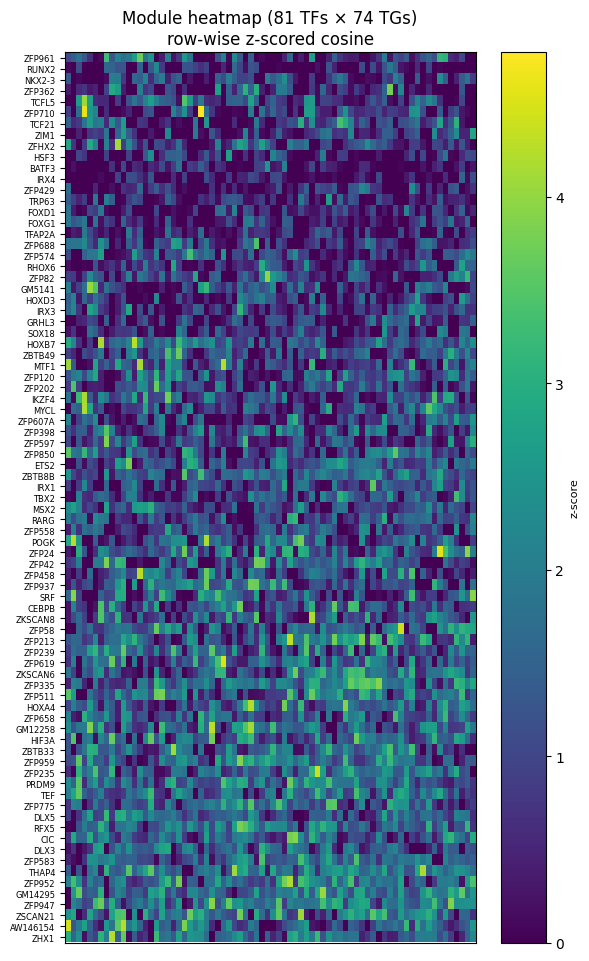

81 TFs × 74 TGs
Mean z: 1.11, median z: 1.09
Frac entries ≥ 1.5: 0.355


In [17]:
import matplotlib.pyplot as plt

def plot_module_heatmap(z, tf_names, tg_names, module, vmax=None):
    tf_idx = [tf_names.index(t) for t in module["tfs"]]
    tg_idx = [tg_names.index(g) for g in module["tgs"]]

    sub = z[np.ix_(tf_idx, tg_idx)]

    # cluster within module
    if sub.shape[0] > 1:
        row_link = linkage(sub, method="average", metric="euclidean")
        row_order = leaves_list(row_link)
    else:
        row_order = np.arange(sub.shape[0])

    if sub.shape[1] > 1:
        col_link = linkage(sub.T, method="average", metric="euclidean")
        col_order = leaves_list(col_link)
    else:
        col_order = np.arange(sub.shape[1])

    sub_re = sub[row_order][:, col_order]
    tf_labels = [module["tfs"][i] for i in row_order]

    fig_w = min(10, max(6, sub_re.shape[1] * 0.04))
    fig_h = min(10, max(4, sub_re.shape[0] * 0.12))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(sub_re,
                   aspect="auto",
                   vmin=0.0,
                   vmax=vmax,
                   cmap="viridis")

    ax.set_yticks(np.arange(len(tf_labels)))
    ax.set_yticklabels(tf_labels, fontsize=6)
    ax.set_xticks([])
    ax.set_title(
        f"Module heatmap ({module['size_tfs']} TFs × {module['size_tgs']} TGs)\n"
        f"row-wise z-scored cosine"
    )
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("z-score", fontsize=8)
    plt.tight_layout()
    plt.show()
    
def summarize_module(z, tf_names, tg_names, module, z_thresh=1.5):
    tf_idx = [tf_names.index(t) for t in module["tfs"]]
    tg_idx = [tg_names.index(g) for g in module["tgs"]]
    sub = z[np.ix_(tf_idx, tg_idx)]
    frac_high = (sub >= z_thresh).mean()
    print(f"{module['size_tfs']} TFs × {module['size_tgs']} TGs")
    print(f"Mean z: {sub.mean():.2f}, median z: {np.median(sub):.2f}")
    print(f"Frac entries ≥ {z_thresh}: {frac_high:.3f}")

plot_module_heatmap(z, tf_names, tg_names, modules[0])
summarize_module(z, tf_names, tg_names, modules[0])


Overlap between modules

In [18]:
for i in range(len(modules)):
    for j in range(i+1, len(modules)):
        overlap = len(set(modules[i]["tgs"]) & set(modules[j]["tgs"]))
        if overlap > 0:
            print(f"Module {i+1} & {j+1}: TG overlap = {overlap}")


Module 1 & 7: TG overlap = 1
Module 1 & 8: TG overlap = 2
Module 2 & 6: TG overlap = 3
Module 2 & 7: TG overlap = 1
Module 3 & 4: TG overlap = 1
Module 4 & 7: TG overlap = 1
Module 4 & 9: TG overlap = 1
Module 5 & 9: TG overlap = 1
Module 6 & 7: TG overlap = 2
Module 6 & 10: TG overlap = 1
Module 7 & 8: TG overlap = 1
Module 7 & 9: TG overlap = 5
Module 7 & 10: TG overlap = 1
Module 8 & 10: TG overlap = 1


Turn modules into a candidate GRN

In [19]:
edges = []
z_thresh_edge = 1.5  # or 2.0

for m in modules:
    tf_idx = [tf_names.index(t) for t in m["tfs"]]
    tg_idx = [tg_names.index(g) for g in m["tgs"]]
    sub = z[np.ix_(tf_idx, tg_idx)]
    tf_list = m["tfs"]
    tg_list = m["tgs"]
    for i, tf in enumerate(tf_list):
        for j, tg in enumerate(tg_list):
            if sub[i, j] >= z_thresh_edge:
                edges.append((tf, tg, float(sub[i, j])))

inferred_net_df = pd.DataFrame()
inferred_net_df["TF"] = [i[0] for i in edges]
inferred_net_df["TG"] = [i[1] for i in edges]
inferred_net_df["Score"] = [i[2] for i in edges]
inferred_net_df.head()

,TF,TG,Score
0,AW146154,1500004A13RIK,4.470517
1,AW146154,ACVR1B,1.753579
2,AW146154,ASPM,1.622869
3,AW146154,ATMIN,3.563672
4,AW146154,CBX2,1.917325


In [20]:
inferred_net_df.to_csv("output/model_classifier_testing/inferred_grn.csv")

### Check module overlap with ChIP-seq

Total ChIP edges in file: 977841
ChIP edges with TF+TG in embedding vocab: 54239
Unique TFs in GT & vocab: 34
Unique TGs in GT & vocab: 6041

[All TFs, cosine] Overall GT fraction: 0.012665265615878576

[All TFs, cosine] GT enrichment in high-score pairs vs rest:
 quantile  threshold  top_n  top_gt_frac  bottom_n  bottom_gt_frac  enrichment_fold
    0.900   0.080323 428250     0.012446   3854250        0.012690         0.980801
    0.950   0.102971 214125     0.012329   4068375        0.012683         0.972112
    0.990   0.145380  42825     0.012423   4239675        0.012668         0.980654
    0.995   0.161018  21413     0.012843   4261087        0.012664         1.014078

[All TFs, cosine] Mann–Whitney (GT > non-GT): p=8.421e-01, GT mean=-0.0001, non-GT mean=0.0000

[ChIP TFs only, cosine] Overall GT fraction: 0.23281738264482676

[ChIP TFs only, cosine] GT enrichment in high-score pairs vs rest:
 quantile  threshold  top_n  top_gt_frac  bottom_n  bottom_gt_frac  enrichment_fold
  

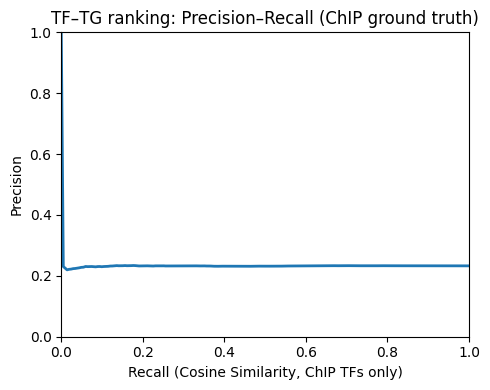

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

# =========================
# 1. Load embeddings + vocab
# =========================

emb = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_embeddings.pt", map_location="cpu")
id2name = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt", map_location="cpu")
eval_dataset = "data/training_data_cache/mESC_holdout"

tf_emb = emb["tf_emb"]            # [T, D]
tg_emb = emb["tg_emb"]            # [G, D]

tf_names = list(id2name["tf_id2name"])
tg_names = list(id2name["tg_id2name"])

T, _ = tf_emb.shape
G, _ = tg_emb.shape

tf_index = {g: i for i, g in enumerate(tf_names)}
tg_index = {g: i for i, g in enumerate(tg_names)}

# cosine similarity matrix [T, G]
tf_norm = F.normalize(tf_emb, p=2, dim=1)
tg_norm = F.normalize(tg_emb, p=2, dim=1)
sim = (tf_norm @ tg_norm.T).cpu().numpy()

# per-TF row-wise z-scores of cosine
mu = sim.mean(axis=1, keepdims=True)
sigma = sim.std(axis=1, keepdims=True) + 1e-6
z = (sim - mu) / sigma   # [T, G]

# =========================
# 2. Load ChIP-seq ground truth
# =========================

chip_path = "data/ground_truth_files/mESC_beeline_ChIP-seq.csv"
chip = pd.read_csv(chip_path)
chip = chip.rename(columns={"Gene1": "tf", "Gene2": "tg"})
chip["tf"] = chip["tf"].astype(str)
chip["tg"] = chip["tg"].astype(str)

print("Total ChIP edges in file:", len(chip))

# keep only edges that exist in our TF/TG vocab
chip["tf_in"] = chip["tf"].isin(tf_index)
chip["tg_in"] = chip["tg"].isin(tg_index)
chip_valid = chip[chip["tf_in"] & chip["tg_in"]].copy()

print("ChIP edges with TF+TG in embedding vocab:", len(chip_valid))
print("Unique TFs in GT & vocab:", chip_valid["tf"].nunique())
print("Unique TGs in GT & vocab:", chip_valid["tg"].nunique())

# set of GT edges (for lookup)
gt_set = set(zip(chip_valid["tf"], chip_valid["tg"]))

# =========================
# 3. Helper: build full pair DF
# =========================

def build_all_pairs_df(scores_matrix, score_name="score", restrict_tf_idx=None):
    """
    scores_matrix: [T, G] array
    restrict_tf_idx: optional list of TF indices to keep (rows)
    """
    if restrict_tf_idx is None:
        tf_idx = np.arange(T)
    else:
        tf_idx = np.array(restrict_tf_idx, dtype=int)

    # indices
    tf_grid, tg_grid = np.meshgrid(tf_idx, np.arange(G), indexing="ij")
    tf_flat = tf_grid.ravel()
    tg_flat = tg_grid.ravel()

    vals = scores_matrix[tf_flat, tg_flat]
    tfs = np.array(tf_names, dtype=object)[tf_flat]
    tgs = np.array(tg_names, dtype=object)[tg_flat]

    df = pd.DataFrame({
        "tf": tfs,
        "tg": tgs,
        score_name: vals,
    })
    df["is_gt"] = list(map(gt_set.__contains__, zip(df["tf"], df["tg"])))
    return df

def enrichment_by_quantile(df, score_col, quantiles=(0.9, 0.95, 0.99, 0.995)):
    rows = []
    for q in quantiles:
        thr = df[score_col].quantile(q)
        top = df[df[score_col] >= thr]
        bottom = df[df[score_col] < thr]
        top_gt = top["is_gt"].mean()
        bot_gt = bottom["is_gt"].mean()
        rows.append({
            "quantile": q,
            "threshold": float(thr),
            "top_n": int(len(top)),
            "top_gt_frac": float(top_gt),
            "bottom_n": int(len(bottom)),
            "bottom_gt_frac": float(bot_gt),
            "enrichment_fold": float(top_gt / (bot_gt + 1e-12)),
        })
    return pd.DataFrame(rows)

def mannwhitney_gt_vs_non(df, score_col):
    gt_scores = df.loc[df["is_gt"], score_col].values
    non_scores = df.loc[~df["is_gt"], score_col].values
    if len(gt_scores) == 0:
        return None

    if len(non_scores) > 500_000:
        rng = np.random.default_rng(0)
        non_scores = rng.choice(non_scores, size=500_000, replace=False)

    u, p = mannwhitneyu(gt_scores, non_scores, alternative="greater")
    return {
        "p": float(p),
        "gt_mean": float(gt_scores.mean()),
        "non_gt_mean": float(non_scores.mean()),
        "n_gt": int(len(gt_scores)),
        "n_non_gt": int(len(non_scores)),
    }

# =========================
# 4. (a) ORIGINAL: all TFs, cosine
# =========================

all_cos = build_all_pairs_df(sim, score_name="score_all")
print("\n[All TFs, cosine] Overall GT fraction:", all_cos["is_gt"].mean())

cos_enr_all = enrichment_by_quantile(all_cos, "score_all")
print("\n[All TFs, cosine] GT enrichment in high-score pairs vs rest:")
print(cos_enr_all.to_string(index=False))

mw_all_cos = mannwhitney_gt_vs_non(all_cos, "score_all")
if mw_all_cos:
    print(f"\n[All TFs, cosine] Mann–Whitney (GT > non-GT): "
          f"p={mw_all_cos['p']:.3e}, "
          f"GT mean={mw_all_cos['gt_mean']:.4f}, "
          f"non-GT mean={mw_all_cos['non_gt_mean']:.4f}")

# =========================
# 5. (a) Restricted: only TFs that appear in ChIP
# =========================

chip_tf_set = set(chip_valid["tf"].unique())
chip_tf_idx = [tf_index[t] for t in chip_tf_set if t in tf_index]

cos_chip_tf = build_all_pairs_df(sim, score_name="score_chip_tf", restrict_tf_idx=chip_tf_idx)
print("\n[ChIP TFs only, cosine] Overall GT fraction:", cos_chip_tf["is_gt"].mean())

cos_enr_chip_tf = enrichment_by_quantile(cos_chip_tf, "score_chip_tf")
print("\n[ChIP TFs only, cosine] GT enrichment in high-score pairs vs rest:")
print(cos_enr_chip_tf.to_string(index=False))

mw_chip_tf_cos = mannwhitney_gt_vs_non(cos_chip_tf, "score_chip_tf")
if mw_chip_tf_cos:
    print(f"\n[ChIP TFs only, cosine] Mann–Whitney (GT > non-GT): "
          f"p={mw_chip_tf_cos['p']:.3e}, "
          f"GT mean={mw_chip_tf_cos['gt_mean']:.4f}, "
          f"non-GT mean={mw_chip_tf_cos['non_gt_mean']:.4f}")

# =========================
# 6. (b) Use per-TF z-scores instead of raw cosine
# =========================

# All TFs, z-score
all_z = build_all_pairs_df(z, score_name="z_all")
print("\n[All TFs, z] Overall GT fraction:", all_z["is_gt"].mean())

z_enr_all = enrichment_by_quantile(all_z, "z_all")
print("\n[All TFs, z] GT enrichment in high-z pairs vs rest:")
print(z_enr_all.to_string(index=False))

mw_all_z = mannwhitney_gt_vs_non(all_z, "z_all")
if mw_all_z:
    print(f"\n[All TFs, z] Mann–Whitney (GT > non-GT): "
          f"p={mw_all_z['p']:.3e}, "
          f"GT mean={mw_all_z['gt_mean']:.4f}, "
          f"non-GT mean={mw_all_z['non_gt_mean']:.4f}")

# ChIP TFs only, z-score
z_chip_tf = build_all_pairs_df(z, score_name="z_chip_tf", restrict_tf_idx=chip_tf_idx)
print("\n[ChIP TFs only, z] Overall GT fraction:", z_chip_tf["is_gt"].mean())

z_enr_chip_tf = enrichment_by_quantile(z_chip_tf, "z_chip_tf")
print("\n[ChIP TFs only, z] GT enrichment in high-z pairs vs rest:")
print(z_enr_chip_tf.to_string(index=False))

mw_chip_tf_z = mannwhitney_gt_vs_non(z_chip_tf, "z_chip_tf")
if mw_chip_tf_z:
    print(f"\n[ChIP TFs only, z] Mann–Whitney (GT > non-GT): "
          f"p={mw_chip_tf_z['p']:.3e}, "
          f"GT mean={mw_chip_tf_z['gt_mean']:.4f}, "
          f"non-GT mean={mw_chip_tf_z['non_gt_mean']:.4f}")

# =========================
# 7. (c) Precision–Recall using cosine similarity (ChIP TFs only)
# =========================

def pr_curve(scores, labels):
    """Compute precision-recall for sorted scores (descending)."""
    order = np.argsort(-scores)
    labels_sorted = labels[order].astype(int)
    tp_cum = np.cumsum(labels_sorted)
    idx = np.arange(1, len(labels_sorted) + 1)

    total_pos = tp_cum[-1]
    if total_pos == 0:
        return np.array([0.0]), np.array([0.0])

    precision = tp_cum / idx
    recall = tp_cum / total_pos
    return precision, recall

# Use cosine similarity for ChIP TFs only (this is the sharpest evaluation)
scores_cos = cos_chip_tf["score_chip_tf"].values
labels = cos_chip_tf["is_gt"].values.astype(int)

prec, rec = pr_curve(scores_cos, labels)

# (Optional) subsample for plotting clarity
def subsample_pr(rec, prec, num=200):
    if len(rec) <= num:
        return rec, prec
    idx = np.linspace(0, len(rec) - 1, num=num).astype(int)
    return rec[idx], prec[idx]

rec_s, prec_s = subsample_pr(rec, prec, num=200)

plt.figure(figsize=(5,4))
plt.plot(rec_s, prec_s, marker="", linewidth=2)
plt.xlabel("Recall (Cosine Similarity, ChIP TFs only)")
plt.ylabel("Precision")
plt.title("TF–TG ranking: Precision–Recall (ChIP ground truth)")
plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()


Total ChIP edges in file: 977841
ChIP edges with TF+TG in embedding vocab: 54239
Unique TFs in GT & vocab: 34
Universe (ChIP TFs only): 34 TFs × 6852 TGs = 232968 pairs

[ChIP TFs only, cosine] Overall GT fraction: 0.232817


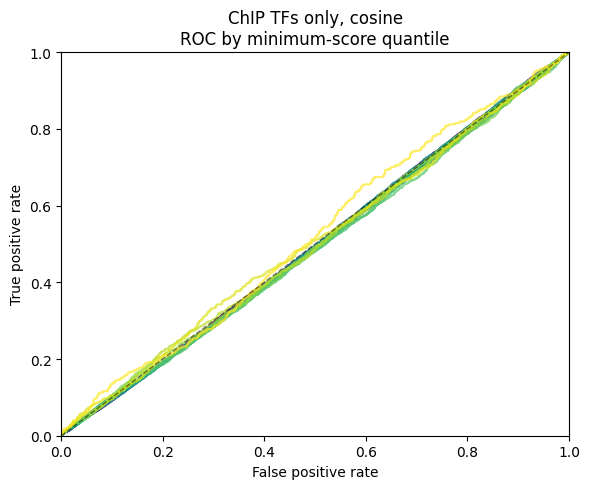

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ----------------- small helpers -----------------

def _canonicalize_name(s: str) -> str:
    # keep this minimal; match whatever you did for vocab/ChIP if needed
    return s.strip()

def _compute_roc_auc(y_true, scores):
    """
    Minimal ROC/AUC for binary labels y_true in {0,1} and real-valued scores.
    Returns fpr, tpr, auc.
    """
    y_true = np.asarray(y_true, dtype=np.int8)
    scores = np.asarray(scores, dtype=np.float64)

    # sort by descending score
    order = np.argsort(-scores)
    y = y_true[order]

    P = y.sum()
    N = len(y) - P
    if P == 0 or N == 0:
        return np.array([0, 1]), np.array([0, 1]), np.nan

    # cumulative TP/FP as we move threshold down
    tp = np.cumsum(y)
    fp = np.cumsum(1 - y)

    tpr = tp / P
    fpr = fp / N

    # prepend (0,0)
    tpr = np.concatenate([[0.0], tpr])
    fpr = np.concatenate([[0.0], fpr])

    # trapezoidal AUC
    auc = np.trapezoid(tpr, fpr)
    return fpr, tpr, auc

# ----------------- main plotting function -----------------

def plot_chiptf_cosine_auroc_by_quantile(
    emb_path,
    vocab_path,
    chip_csv_path,
    quantile_step=0.01,
    cmap_name="viridis",
):
    """
    For the 'ChIP TFs only, cosine' group:
      - build all TF–TG pairs for TFs that appear in ChIP ground truth
      - label them as GT / non-GT
      - for q in [0, 0.05, ..., 0.95]:
          * keep only pairs with score >= quantile(q)
          * compute ROC and AUROC within that subset
      - plot all ROC curves with a color gradient.

    emb_path: path to tf_tg_embeddings.pt
    vocab_path: path to tf_tg_vocab_id2name.pt
    chip_csv_path: path to ChIP-seq ground-truth CSV
    """

    # ----- load embeddings + vocab -----
    emb = torch.load(emb_path, map_location="cpu")
    tf_emb = emb["tf_emb"]        # [T, D]
    tg_emb = emb["tg_emb"]        # [G, D]

    id2name = torch.load(vocab_path, map_location="cpu")
    tf_names = [ _canonicalize_name(n) for n in id2name["tf_id2name"] ]
    tg_names = [ _canonicalize_name(n) for n in id2name["tg_id2name"] ]

    T, D = tf_emb.shape
    G, _ = tg_emb.shape

    # cosine similarities
    tf_norm = F.normalize(tf_emb, p=2, dim=1)
    tg_norm = F.normalize(tg_emb, p=2, dim=1)
    sim = (tf_norm @ tg_norm.T).cpu().numpy()   # [T, G]

    # ----- load ChIP ground truth -----
    chip_df = pd.read_csv(chip_csv_path)
    chip_df["Gene1"] = chip_df["Gene1"].map(_canonicalize_name)
    chip_df["Gene2"] = chip_df["Gene2"].map(_canonicalize_name)

    # map names -> indices
    tf_name2idx = {n: i for i, n in enumerate(tf_names)}
    tg_name2idx = {n: i for i, n in enumerate(tg_names)}

    # keep only edges where TF + TG are in vocab and TF is in TF vocab
    chip_edges = []
    for tf, tg in zip(chip_df["Gene1"], chip_df["Gene2"]):
        ti = tf_name2idx.get(tf)
        gi = tg_name2idx.get(tg)
        if ti is not None and gi is not None:
            chip_edges.append((ti, gi))

    chip_edges = np.array(chip_edges, dtype=int)
    print(f"Total ChIP edges in file: {len(chip_df)}")
    print(f"ChIP edges with TF+TG in embedding vocab: {len(chip_edges)}")

    if len(chip_edges) == 0:
        raise ValueError("No overlapping ChIP edges with embedding vocab.")

    # ----- restrict to 'ChIP TFs only' universe -----
    chiptf_idx = np.unique(chip_edges[:, 0])          # TF indices with ChIP info
    print(f"Unique TFs in GT & vocab: {len(chiptf_idx)}")

    # all candidate pairs for these TFs x all TGs
    # shape: [n_chiptf, G]
    sim_sub = sim[chiptf_idx, :]
    n_tf_sub, n_tg = sim_sub.shape
    print(f"Universe (ChIP TFs only): {n_tf_sub} TFs × {n_tg} TGs = {n_tf_sub * n_tg} pairs")

    # build GT mask in this universe
    gt_mask = np.zeros_like(sim_sub, dtype=bool)
    # remap row indices: chiptf_idx_pos[tf_global] = row position
    tf_global_to_row = {tf: i for i, tf in enumerate(chiptf_idx)}
    for ti, gi in chip_edges:
        row = tf_global_to_row.get(ti)
        if row is not None and 0 <= gi < n_tg:
            gt_mask[row, gi] = True

    # flatten
    scores_flat = sim_sub.reshape(-1)
    y_flat = gt_mask.reshape(-1).astype(int)

    overall_frac = y_flat.mean()
    print(f"\n[ChIP TFs only, cosine] Overall GT fraction: {overall_frac:.6f}")

    # ----- ROC curves by quantile subset -----
    quantiles = np.arange(0.8, 1.0, quantile_step)
    cmap = plt.get_cmap(cmap_name)
    fig, ax = plt.subplots(figsize=(6, 5))

    for i, q in enumerate(quantiles):
        thr = np.quantile(scores_flat, q)
        mask = scores_flat >= thr
        y_sub = y_flat[mask]
        s_sub = scores_flat[mask]

        # skip degenerate subsets
        if y_sub.sum() == 0 or y_sub.sum() == len(y_sub):
            continue

        fpr, tpr, auc = _compute_roc_auc(y_sub, s_sub)

        color = cmap(float(i) / max(1, len(quantiles)-1))
        ax.plot(fpr, tpr, color=color, lw=1.5, alpha=0.7)

    # diagonal baseline
    ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.set_title("ChIP TFs only, cosine\nROC by minimum-score quantile")

    plt.tight_layout()
    plt.show()
    return fig

fig = plot_chiptf_cosine_auroc_by_quantile(
    emb_path=SELECTED_EXPERIMENT_DIR / "tf_tg_embeddings.pt",
    vocab_path=SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt",
    chip_csv_path="data/ground_truth_files/mESC_beeline_ChIP-seq.csv",
    quantile_step=0.01
)

Total ChIP edges in file: 977841
ChIP edges with TF+TG in embedding vocab: 54239
Unique TFs in GT & vocab: 34
Unique TGs in GT & vocab: 6041


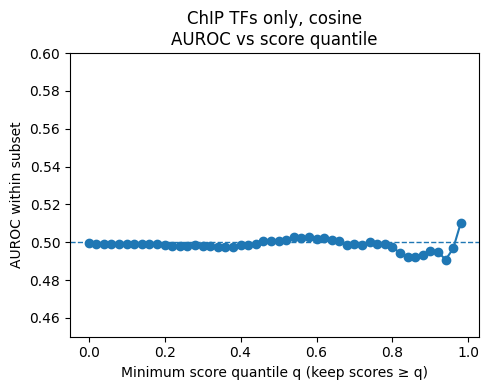

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def plot_auroc_vs_quantile(scores, labels, q_step=0.05):
    """
    For a given score+label vector:
      - For each quantile q in [0, 1-q_step], keep pairs with score >= q-quantile.
      - Compute AUROC within that subset.
      - Plot AUROC vs q.
    """
    scores = np.asarray(scores)
    labels = np.asarray(labels).astype(bool)

    quantiles = np.arange(0.0, 1.0, q_step)
    results = []

    for q in quantiles:
        thr = np.quantile(scores, q)
        mask = scores >= thr
        s_sub = scores[mask]
        y_sub = labels[mask]

        # need both classes present; otherwise AUROC is undefined
        if y_sub.sum() == 0 or y_sub.sum() == len(y_sub):
            auroc = np.nan
        else:
            auroc = roc_auc_score(y_sub, s_sub)

        results.append((q, thr, mask.sum(), auroc))

    # ---- Plot ----
    qs = np.array([r[0] for r in results])
    aucs = np.array([r[3] for r in results])

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(qs, aucs, marker="o")
    ax.axhline(0.5, linestyle="--", linewidth=1)
    ax.set_xlabel("Minimum score quantile q (keep scores ≥ q)")
    ax.set_ylabel("AUROC within subset")
    ax.set_title("ChIP TFs only, cosine\nAUROC vs score quantile")
    ax.set_ylim(0.45, 0.6)  # adjust if your values go outside this

    plt.tight_layout()
    plt.show()

    return results

# =========================
# 2. Load ChIP-seq ground truth
# =========================

chip_path = "data/ground_truth_files/mESC_beeline_ChIP-seq.csv"
chip = pd.read_csv(chip_path)
chip = chip.rename(columns={"Gene1": "tf", "Gene2": "tg"})
chip["tf"] = chip["tf"].astype(str)
chip["tg"] = chip["tg"].astype(str)

print("Total ChIP edges in file:", len(chip))

# keep only edges that exist in our TF/TG vocab
chip["tf_in"] = chip["tf"].isin(tf_index)
chip["tg_in"] = chip["tg"].isin(tg_index)
chip_valid = chip[chip["tf_in"] & chip["tg_in"]].copy()

print("ChIP edges with TF+TG in embedding vocab:", len(chip_valid))
print("Unique TFs in GT & vocab:", chip_valid["tf"].nunique())
print("Unique TGs in GT & vocab:", chip_valid["tg"].nunique())

# set of GT edges (for lookup)
gt_set = set(zip(chip_valid["tf"], chip_valid["tg"]))

chip_tfs = {tf for (tf, _) in gt_set}
mask_chip_tf = tf_tg_sim_melted["source_id"].isin(chip_tfs)

scores_chip_tf_cos = tf_tg_sim_melted.loc[mask_chip_tf, "score"].to_numpy()
labels_chip_tf = tf_tg_sim_melted.loc[mask_chip_tf, ["source_id","target_id"]] \
    .apply(lambda r: (r["source_id"], r["target_id"]) in gt_set, axis=1) \
    .to_numpy()

results_chip_tf_cos = plot_auroc_vs_quantile(scores_chip_tf_cos, labels_chip_tf, q_step=0.02)


## Gradient Attribution

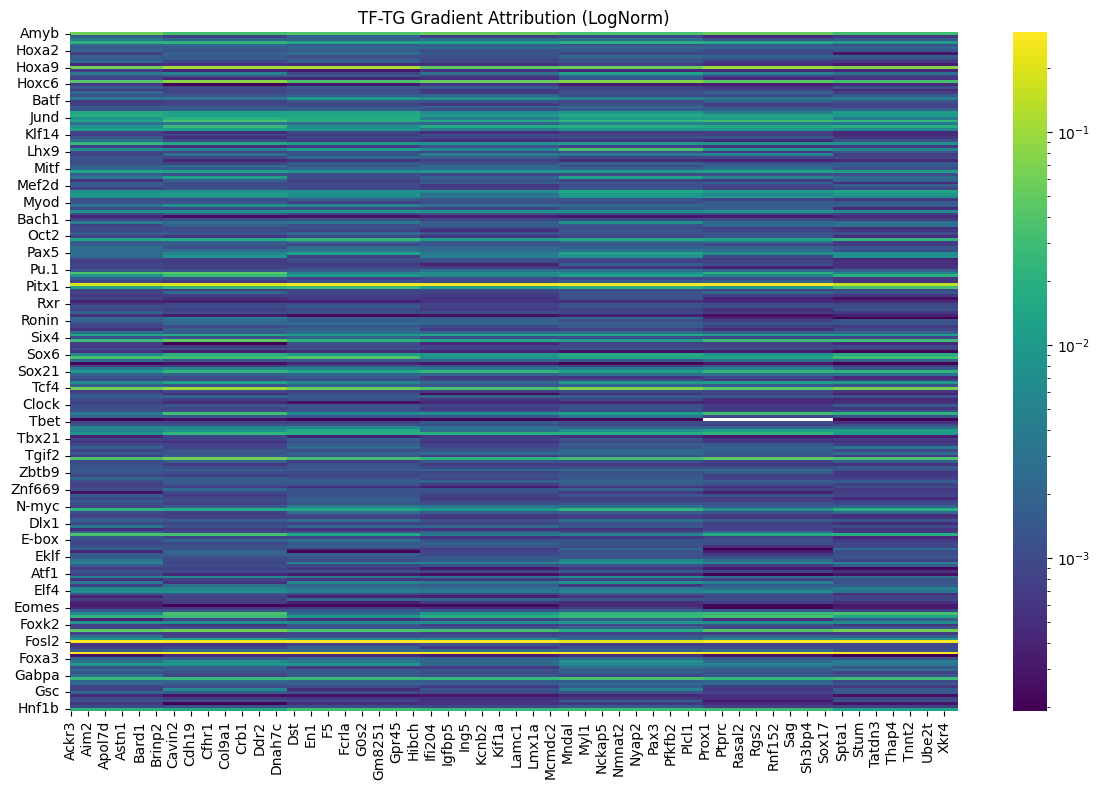

In [8]:
import seaborn as sns
from matplotlib.colors import LogNorm

df_subset = gradient_attribution_df.loc[
    [idx for idx in gradient_attribution_df.index if len(str(idx)) < 7],      # row filter
    [col for col in gradient_attribution_df.columns if len(str(col)) < 7]    # column filter
]

data = df_subset.iloc[:100, :100].copy()
vmin = max(1e-9, float(data[data > 0].min().min()))
vmax = float(data.max().max())

plt.figure(figsize=(12,8))
sns.heatmap(df_subset, cmap="viridis", norm=LogNorm(vmin=vmin, vmax=vmax))
plt.title("TF-TG Gradient Attribution (LogNorm)")
plt.tight_layout()
plt.show()

## Shortcut Matrix

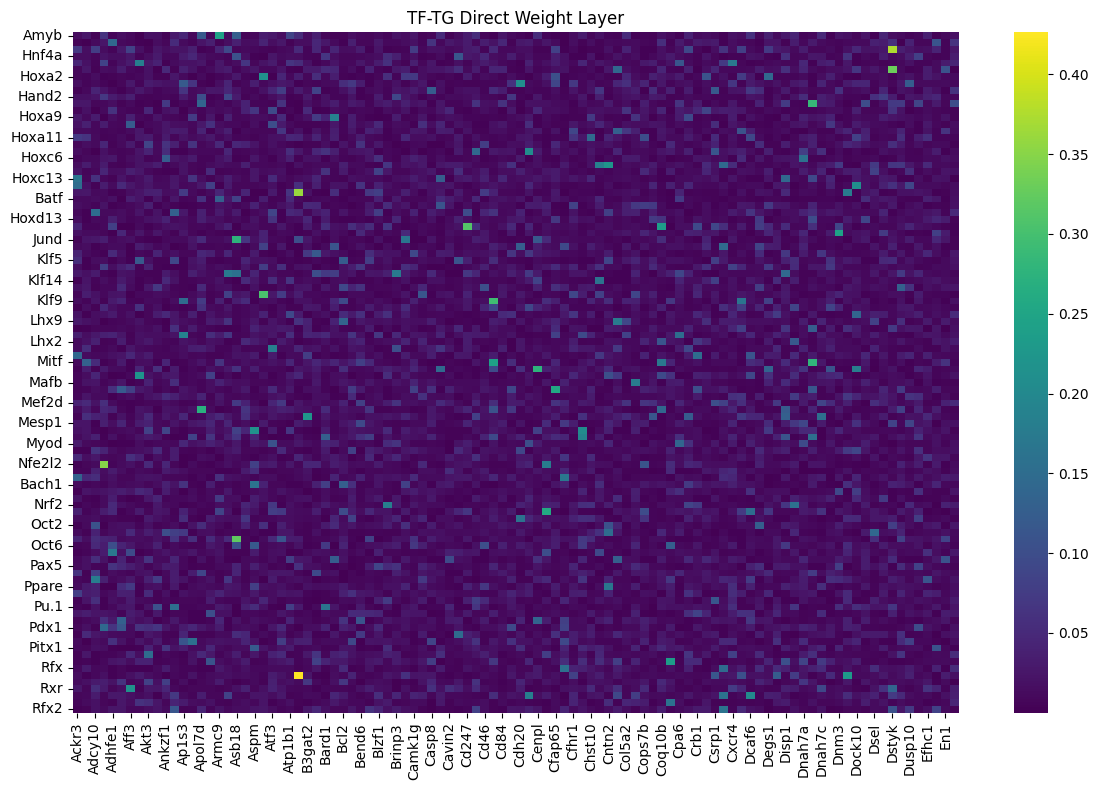

In [7]:
import seaborn as sns

df_subset = shortcut_matrix_df.loc[
    [idx for idx in shortcut_matrix_df.index if len(str(idx)) < 7],      # row filter
    [col for col in shortcut_matrix_df.columns if len(str(col)) < 7]    # column filter
]
plt.figure(figsize=(12,8))
sns.heatmap(df_subset.iloc[:100, :100], cmap="viridis")
plt.title("TF-TG Direct Weight Layer")
plt.tight_layout()
plt.show()

In [11]:
tf_imp_dir = os.path.join(SELECTED_EXPERIMENT_DIR, "test_results")
            
tf_importance_df = pd.read_csv(os.path.join(tf_imp_dir, "shortcut_matrix.csv"), header=0, index_col=0)

fig = plt.figure(figsize=(10,5))

selected_tg = tf_importance_df.index[0]
selected_tf_row = tf_importance_df.iloc[0]
selected_tf_row = selected_tf_row.iloc[:50].sort_values(ascending=False)

plt.xticks(rotation=90, fontsize=10)
plt.bar(x=selected_tf_row.index, height=selected_tf_row)
plt.title(f"TF Importance for {selected_tg}")
plt.ylabel("TF Importance")
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC_no_scale_linear/chr1/model_training_021/test_results/shortcut_matrix.csv'

In [30]:
from grn_inference.utils import minmax_norm_col

In [31]:
edges_df = (
    tf_importance_df
    .reset_index()
    .melt(id_vars="index", var_name="Target", value_name="score")
    .rename(columns={"index": "Source"})
)

print(edges_df.head())
edges_df["score"] = minmax_norm_col(edges_df["score"])
edges_df.to_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "inferred_grn.csv"), header=True, index=False)

  Source         Target     score
0   Amyb  1110059e24rik  0.012926
1   Ap-1  1110059e24rik  0.007593
2  Atoh1  1110059e24rik  0.002979
3  Hnf4a  1110059e24rik  0.016630
4   Hnf6  1110059e24rik  0.059909


In [ ]:
tf_importance_df.melt()

,1110059e24rik,1700028p14rik,1700054a03rik,4430402i18rik,4930414n06rik,4930481a15rik,4930505n22rik,A1cf,A330040f15rik,A930007i19rik,...,Trpt1,Tsga10ip,Unc93b1,Vldlr,Vps13a,Vti1a,Vwa2,Wnt8b,Yif1a,Zfand5
Amyb,0.012926,0.007979,0.016949,0.071295,0.038051,0.005369,0.004322,0.052676,0.039596,0.004102,...,0.021498,0.008520,0.030714,0.005480,0.018128,0.010033,0.005197,0.023149,0.054277,0.013118
Ap-1,0.007593,0.016408,0.060694,0.075351,0.003203,0.018191,0.025439,0.010395,0.014900,0.006479,...,0.005965,0.112763,0.024329,0.004895,0.008635,0.009053,0.069101,0.052359,0.032719,0.007553
Atoh1,0.002979,0.008848,0.006363,0.017177,0.027394,0.096839,0.007401,0.006691,0.040941,0.011984,...,0.007331,0.024119,0.021316,0.077002,0.085251,0.058651,0.088675,0.007731,0.019807,0.007677
Hnf4a,0.016630,0.025051,0.012493,0.036420,0.022744,0.012015,0.047341,0.020354,0.005996,0.003615,...,0.006587,0.020681,0.005124,0.049497,0.018169,0.001901,0.020302,0.002485,0.004840,0.071207
Hnf6,0.059909,0.013033,0.030434,0.009828,0.022351,0.014792,0.024875,0.005045,0.006072,0.004852,...,0.052047,0.005143,0.016318,0.004523,0.032682,0.002094,0.002916,0.013019,0.024267,0.088734


In [26]:
def evaluate_chip_aucs(tf_importance_df, chip_df, k_list=(100, 500, 1000, 5000)):
    """
    Evaluate AUROC / PR-AUC / Precision K against CHIP edges.
    We uppercase both the CHIP and the DF indexing to align.
    """
    chip_edges = {(t.upper(), g.upper()) for t, g in zip(chip_df["TF"], chip_df["TG"])}

    # Uppercase DF indexing for matching
    tf_imp = tf_importance_df.copy()
    tf_imp.index   = [x.upper() for x in tf_imp.index]
    tf_imp.columns = [x.upper() for x in tf_imp.columns]

    rn111_tfs = {t for t, _ in chip_edges}
    rn111_tgs = {g for _, g in chip_edges}

    tf_imp = tf_imp.loc[tf_imp.index.intersection(rn111_tfs),
                        tf_imp.columns.intersection(rn111_tgs)]
    if tf_imp.empty:
        raise ValueError("No overlap between TF/TG names and CHIP set.")

    scores, labels, edges = [], [], []
    # Flatten
    for tg in tf_imp.columns:
        col = tf_imp[tg]
        for tf, score in col.items():
            scores.append(float(score))
            labels.append(1 if (tf, tg) in chip_edges else 0)
            edges.append((tf, tg))

    if len(set(labels)) < 2:
        raise ValueError("Only one class present after overlap; AUROC/PR-AUC undefined.")

    auroc = roc_auc_score(labels, scores)
    auprc = average_precision_score(labels, scores)

    # Precision K
    df_scored = pd.DataFrame(edges, columns=["tf", "tg"])
    df_scored["score"] = scores
    df_scored["label"] = labels
    df_scored = df_scored.sort_values("score", ascending=False).reset_index(drop=True)

    results = {"AUROC": auroc, "PR-AUC": auprc, "positives": int(sum(labels)), "edges": int(len(labels))}
    for k in k_list:
        k = int(k)
        if k <= len(df_scored):
            prec_k = df_scored.head(k)["label"].mean()
            results[f"Precision@{k}"] = float(prec_k)

    return results, df_scored

results, df_scored = evaluate_chip_aucs(tf_importance_df, rn115_ground_truth, k_list=(100, 500, 1000, 5000))

print(f"AUROC = {results['AUROC']:.4f}  |  PR-AUC = {results['PR-AUC']:.4f}  "
        f"| positives={results['positives']} / {results['edges']} edges")
for k in (100, 500, 1000, 5000):
    key = f"AUROC@{k}"
    if key in results:
        print(f"{key}: {results[key]:.3f}")


AUROC = 0.5003  |  PR-AUC = 0.1710  | positives=397 / 2544 edges


In [ ]:
import torch
training_data_cache = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/training_data_cache/mESC"

total_moods_site_df_list = []
peak_gene_dist_df_list = []

for subdir in os.listdir(training_data_cache):
    if "chr" in subdir:
        chr_path = os.path.join(training_data_cache, subdir)
        
        moods_path = os.path.join(chr_path, f"moods_sites_{subdir}.tsv")
        peak_gene_dist = os.path.join(chr_path, f"genes_near_peaks_{subdir}.parquet")
        
        if os.path.isfile(moods_path):
            chr_moods_sites_df = pd.read_csv(moods_path, sep="\t")
            total_moods_site_df_list.append(chr_moods_sites_df)
            
        if os.path.isfile(peak_gene_dist):
            chr_peak_gene_dist_df = pd.read_parquet(peak_gene_dist, engine="pyarrow")
            peak_gene_dist_df_list.append(chr_peak_gene_dist_df)

total_moods_sites = pd.concat(total_moods_site_df_list)
total_peak_gene_dist = pd.concat(peak_gene_dist_df_list)


In [37]:
print("Moods DataFrame")
print(total_moods_sites.head())
print()
print("peak-gene distance dataframe")
print(total_peak_gene_dist.head())

Moods DataFrame
                    peak_id         TF    pos   logodds strand
0  chr5:100004870-100005470  At3g46070  285.0  4.201540      -
1  chr5:100007878-100008478  At3g46070  162.0  4.902650      -
2  chr5:100039792-100040392  At3g46070  559.0  3.333572      -
3  chr5:100047809-100048409  At3g46070   73.0  4.902650      +
4  chr5:100053808-100054408  At3g46070  496.0  4.902650      -

peak-gene distance dataframe
       peak_chr  peak_start   peak_end                   peak_id gene_chr  \
152413     chr5   146230649  146231249  chr5:146230649-146231249     chr5   
30781      chr5   113772200  113772800  chr5:113772200-113772800     chr5   
176649     chr5    24901975   24902575    chr5:24901975-24902575     chr5   
81751      chr5   124174791  124175391  chr5:124174791-124175391     chr5   
103648     chr5   135064344  135064944  chr5:135064344-135064944     chr5   

        gene_start   gene_end     target_id  TSS_dist  TSS_dist_score  
152413   146231249  146231249          Cd

In [38]:
tf_tg_links = total_moods_sites.merge(total_peak_gene_dist, on="peak_id", how="inner")
print(tf_tg_links.head())

MemoryError: Unable to allocate 51.9 GiB for an array with shape (2, 3479631642) and data type object

In [ ]:
tf_tg_features = (
    tf_tg_links.groupby(["TF", "target_id"])
    .agg(
        n_peaks_linking=("peak_id", "nunique"),
        n_motifs_linking=("logodds", "count"),
        mean_motif_score=("logodds", "mean"),
        max_motif_score=("logodds", "max"),
        min_tss_dist=("TSS_dist", "min"),
        mean_tss_dist=("TSS_dist", "mean"),
        mean_tss_score=("TSS_dist_score", "mean")
    )
    .reset_index()
    .rename(columns={"target_id": "TG"})
)
print(tf_tg_features.head())

In [ ]:
tf_tg_features["motif_density"] = (
    tf_tg_features["n_motifs_linking"] / (tf_tg_features["n_peaks_linking"] + 1e-6)
)
tf_tg_features["log_mean_score"] = np.log1p(tf_tg_features["mean_motif_score"])
tf_tg_features["neg_log_tss"] = -np.log1p(tf_tg_features["mean_tss_dist"])
